In [2]:
# !pip install -r requirements.txt

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik.report import plot_correlation_matrix

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.pipeline import Pipeline

# дополнительные библиотеки
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# для сохранения модели
import joblib
import json

# Оформление
from IPython.display import display, HTML

display(HTML("<style>.container {width:100% !important;} </style>")) # подгоняем размер тетрадки под ширину экрана
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>")) # иногда не работает та, что выше

pd.options.display.max_columns=None
pd.set_option('display.width', 1000) # для вывода всех колонок в ширину
pd.options.display.float_format = '{:.2f}'.format # удобнее смотреть на конечное кол-во цифр в выводе

# Чтобы пофиксить предупреждения
import warnings
warnings.filterwarnings("ignore")

In [76]:
# Устанавливаем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Шаг 1. Первичное исследование и предобработка данных

In [77]:
# импорт данных
heart_train = pd.read_csv("data/heart_train.csv")
heart_test = pd.read_csv("data/heart_test.csv")

# создаем словарь
df_dict = {'heart_train': heart_train,
           'heart_test': heart_test}

# cделаем первичное исследование для дальнейшей предобработки данных
for df_name, df in df_dict.items():
    print('-' * 80, df_name)

    print('-' * 60, 'df.info()')
    df.info()
    print()
    
    print('-' * 60, 'df.describe(include="number")', end='\n\n')
    display(df.describe(include='number'))

    print('-' * 60, 'df.describe(exclude="number")', end='\n\n')
    display(df.describe(exclude='number'))

    print('-' * 60, 'df.sample(5)')
    display(df.sample(5))

-------------------------------------------------------------------------------- heart_train
------------------------------------------------------------ df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.00,8685.00,8685.00,8685.00,8442.00,8442.00,8442.00,8442.00,8442.00,8685.00,8685.00,8442.00,8442.00,8442.00,8685.00,8685.00,8685.00,8685.00,8442.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00
mean,4342.00,0.45,0.50,0.05,0.65,0.49,0.90,0.50,0.60,0.50,1.06,0.50,0.50,5.49,0.50,0.50,0.50,0.51,3.51,0.50,0.35,0.23,0.05,0.04,0.45,0.50,4831.21
std,2507.29,0.23,0.28,0.02,0.48,0.50,0.30,0.50,0.49,0.28,0.87,0.50,0.50,2.87,0.29,0.28,0.28,0.29,2.28,0.33,0.48,0.08,0.08,0.06,0.17,0.17,2782.59
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2171.00,0.26,0.27,0.03,0.00,0.00,1.00,0.00,0.00,0.26,0.00,0.00,0.00,3.00,0.26,0.25,0.25,0.26,2.00,0.17,0.00,0.23,0.05,0.04,0.30,0.35,2425.00
50%,4342.00,0.46,0.50,0.05,1.00,0.00,1.00,0.00,1.00,0.50,1.00,0.00,1.00,5.00,0.50,0.49,0.49,0.50,3.00,0.50,0.00,0.23,0.05,0.04,0.45,0.50,4837.00
75%,6513.00,0.64,0.75,0.07,1.00,1.00,1.00,1.00,1.00,0.75,2.00,1.00,1.00,8.00,0.74,0.74,0.74,0.75,6.00,0.83,1.00,0.23,0.05,0.04,0.60,0.65,7242.00
max,8684.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,10.00,1.00,1.00,1.00,1.00,7.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,9650.00


------------------------------------------------------------ df.describe(exclude="number")



,Gender
count,8685
unique,4
top,Male
freq,5882


------------------------------------------------------------ df.sample(5)


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
5890,5890,0.52,0.11,0.05,1.00,1.00,1.00,1.00,1.00,0.78,1,0.00,0.00,6.00,0.39,0.95,0.90,0.22,5.00,0.50,0.00,0.23,0.05,0.04,Male,0.23,0.37,7567
7185,7185,0.81,0.13,0.07,1.00,1.00,1.00,1.00,0.00,0.41,1,0.00,0.00,1.00,0.92,0.51,0.51,0.01,5.00,1.00,0.00,0.23,0.05,0.04,Female,0.43,0.55,3665
7688,7688,0.81,0.27,0.03,1.00,0.00,1.00,0.00,1.00,0.03,2,0.00,0.00,10.00,0.65,0.92,0.83,0.99,4.00,0.67,1.00,0.23,0.05,0.04,Female,0.73,0.70,8058
5557,5557,0.78,0.95,0.07,1.00,1.00,1.00,0.00,0.00,0.93,2,1.00,1.00,2.00,0.96,0.83,0.41,0.93,7.00,0.50,0.00,0.23,0.05,0.04,Male,0.16,0.33,8225
4888,4888,0.82,0.82,0.02,1.00,1.00,1.00,1.00,1.00,0.10,0,1.00,1.00,7.00,0.26,0.56,0.68,0.09,4.00,0.50,0.00,0.23,0.05,0.04,Male,0.32,0.77,8875


-------------------------------------------------------------------------------- heart_test
------------------------------------------------------------ df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.00,966.00,966.00,966.00,935.00,935.00,935.00,935.00,935.00,966.00,966.00,935.00,935.00,935.00,966.00,966.00,966.00,966.00,935.00,966.00,966.00,966.00,966.00,966.00,966.00,966.00
mean,482.50,0.45,0.49,0.05,0.66,0.48,0.90,0.52,0.58,0.49,1.05,0.49,0.49,5.33,0.51,0.48,0.48,0.49,3.44,0.51,0.22,0.05,0.03,0.45,0.50,4769.16
std,279.00,0.23,0.28,0.04,0.48,0.50,0.30,0.50,0.49,0.28,0.88,0.50,0.50,2.86,0.29,0.27,0.29,0.28,2.30,0.32,0.07,0.08,0.05,0.17,0.17,2818.82
min,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.12,0.00
25%,241.25,0.25,0.24,0.04,0.00,0.00,1.00,0.00,0.00,0.24,0.00,0.00,0.00,3.00,0.26,0.26,0.22,0.25,1.00,0.17,0.23,0.05,0.04,0.30,0.35,2275.75
50%,482.50,0.46,0.50,0.05,1.00,0.00,1.00,1.00,1.00,0.50,1.00,0.00,0.00,5.00,0.50,0.49,0.47,0.49,3.00,0.50,0.23,0.05,0.04,0.45,0.49,4769.50
75%,723.75,0.64,0.71,0.07,1.00,1.00,1.00,1.00,1.00,0.73,2.00,1.00,1.00,8.00,0.76,0.71,0.72,0.72,5.00,0.83,0.23,0.05,0.04,0.60,0.64,7206.00
max,965.00,0.85,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,10.00,1.00,1.00,1.00,1.00,7.00,1.00,0.75,1.00,0.97,0.74,0.79,9644.00


------------------------------------------------------------ df.describe(exclude="number")



,Gender
count,966
unique,4
top,Male
freq,650


------------------------------------------------------------ df.sample(5)


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
600,600,0.49,0.71,0.05,0.00,0.00,1.00,0.00,1.00,0.78,0,0.00,0.00,2.00,0.18,0.52,0.70,0.55,1.00,0.83,0.30,0.04,0.10,Male,0.27,0.59,5781
700,700,0.40,0.57,0.05,1.00,1.00,1.00,0.00,1.00,0.07,1,1.00,1.00,7.00,0.31,0.51,0.94,0.39,3.00,0.67,0.09,0.01,0.01,Male,0.24,0.27,7908
261,261,0.15,0.05,0.03,1.00,1.00,0.00,0.00,1.00,0.85,1,0.00,0.00,6.00,0.76,0.18,0.22,0.35,1.00,1.00,0.23,0.05,0.04,Female,0.35,0.41,80
405,405,0.25,0.85,0.06,1.00,1.00,1.00,0.00,1.00,0.77,2,0.00,1.00,4.00,0.34,0.58,0.56,0.17,7.00,0.67,0.23,0.05,0.04,Male,0.74,0.30,4385
113,113,0.39,0.26,0.05,1.00,0.00,1.00,1.00,0.00,0.93,1,1.00,1.00,10.00,0.81,0.89,0.97,0.70,3.00,0.33,0.23,0.05,0.04,Male,0.68,0.63,4284


In [78]:
# Проверим что за значения в признаке Gender, т.к. сейчас их 4, а не 2
print('Уникальные значения пола в признаке Gender:')
print(list(heart_train.Gender.unique()), end='\n\n')

# Создадим переменные, чтобы код был чище
hrt_gnd = heart_train[~heart_train['Gender'].isin(['Male','Female'])]
hrt_isna = heart_train[heart_train.isna().any(axis=1)]

# Посмотрим на строки, в которых пол обозначен цифрой
print(f'Количество строк, в которых пол обозначен цифрой: {hrt_gnd.shape[0]}')
display(hrt_gnd.head())

# Посмотрим на строки, в которых есть пропуски в данных
print(f'Количество строк, в которых присутствуют пропуски: {hrt_isna.shape[0]}')
display(hrt_isna.head())

# Посмотрим какой % от всего датафрейма занимают эти строки
print(f'Доля строк с пропусками и цифрой-полом от общего числа строк: {round(hrt_gnd.shape[0] / heart_train.shape[0], 2)}')


Уникальные значения пола в признаке Gender:
['Male', 'Female', '1.0', '0.0']

Количество строк, в которых пол обозначен цифрой: 243


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
16,16,0.45,0.50,0.06,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.23,0.03,0.00,1.0,0.39,0.26,9528
90,90,0.37,0.50,0.07,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.15,0.00,0.04,1.0,0.26,0.34,9640
92,92,0.63,0.50,0.07,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.26,0.01,0.00,0.0,0.26,0.23,9515
185,185,0.52,0.50,0.05,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.56,0.01,0.00,0.0,0.17,0.15,9491
188,188,0.27,0.50,0.04,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.11,0.05,0.00,0.0,0.23,0.16,9448


Количество строк, в которых присутствуют пропуски: 243


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
16,16,0.45,0.50,0.06,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.23,0.03,0.00,1.0,0.39,0.26,9528
90,90,0.37,0.50,0.07,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.15,0.00,0.04,1.0,0.26,0.34,9640
92,92,0.63,0.50,0.07,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.26,0.01,0.00,0.0,0.26,0.23,9515
185,185,0.52,0.50,0.05,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.56,0.01,0.00,0.0,0.17,0.15,9491
188,188,0.27,0.50,0.04,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.00,0.11,0.05,0.00,0.0,0.23,0.16,9448


Доля строк с пропусками и цифрой-полом от общего числа строк: 0.03


Проверим такая ли ситуация в тестовых данных

In [79]:
# Проверим что за значения в признаке Gender, т.к. сейчас их 4, а не 2
print('Уникальные значения пола в признаке Gender:')
print(list(heart_test.Gender.unique()), end='\n\n')

# Создадим переменные, чтобы код был чище
hrt_gnd = heart_test[~heart_test['Gender'].isin(['Male','Female'])]
hrt_isna = heart_test[heart_test.isna().any(axis=1)]

# Посмотрим на строки, в которых пол обозначен цифрой
print(f'Количество строк, в которых пол обозначен цифрой: {hrt_gnd.shape[0]}')
display(hrt_gnd.head())

# Посмотрим на строки, в которых есть пропуски в данных
print(f'Количество строк, в которых присутствуют пропуски: {hrt_isna.shape[0]}')
display(hrt_isna.head())

# Посмотрим какой % от всего датафрейма занимают эти строки
print(f'Доля строк с пропусками и цифрой-полом от общего числа строк: {round(hrt_gnd.shape[0] / heart_test.shape[0], 2)}')


Уникальные значения пола в признаке Gender:
['Male', 'Female', '1.0', '0.0']

Количество строк, в которых пол обозначен цифрой: 31


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
27,27,0.37,0.50,0.03,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.18,0.01,0.00,1.0,0.42,0.44,9613
37,37,0.57,0.50,0.04,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.17,0.01,0.00,1.0,0.72,0.73,9471
58,58,0.52,0.50,0.05,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.10,0.04,0.00,1.0,0.39,0.50,9486
60,60,0.37,0.50,0.06,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.20,0.01,0.01,1.0,0.39,0.22,9391
61,61,0.48,0.50,0.03,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.11,0.01,0.00,1.0,0.42,0.33,9579


Количество строк, в которых присутствуют пропуски: 31


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
27,27,0.37,0.50,0.03,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.18,0.01,0.00,1.0,0.42,0.44,9613
37,37,0.57,0.50,0.04,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.17,0.01,0.00,1.0,0.72,0.73,9471
58,58,0.52,0.50,0.05,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.10,0.04,0.00,1.0,0.39,0.50,9486
60,60,0.37,0.50,0.06,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.20,0.01,0.01,1.0,0.39,0.22,9391
61,61,0.48,0.50,0.03,NaN,NaN,NaN,NaN,NaN,0.50,3,NaN,NaN,NaN,0.50,0.49,0.49,0.50,NaN,0.50,0.11,0.01,0.00,1.0,0.42,0.33,9579


Доля строк с пропусками и цифрой-полом от общего числа строк: 0.03


Да, ситуация ровно такая же, поэтому исходя из того, что: 
- строки с пропусками и строки с полом (которые обозначены цифрами) совпадают  
- и их доля от общего количества строк не превышает 3%

Мы можем их удалить и передать эти данные команде, которая снабжает нас исходными данными, чтобы это исправили в будущем.

In [80]:
# удалим строки с пропусками
for df_name, df in df_dict.items():
    print(f'{df_name}:')
    rows_before = df.shape[0]
    print(f'Строк до удаления: {rows_before}')
    drop_index = df[~df['Gender'].isin(['Male','Female'])].index
    df.drop(drop_index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f'После удаления пропусков осталось строк: {df.shape[0]} (пропусков удалено: {rows_before - df.shape[0]})', end='\n\n')

    del df_name, df

heart_train:
Строк до удаления: 8685
После удаления пропусков осталось строк: 8442 (пропусков удалено: 243)

heart_test:
Строк до удаления: 966
После удаления пропусков осталось строк: 935 (пропусков удалено: 31)



В наших данных есть поле `Unnamed: 0`, которое дублирует текущий индекс:

In [81]:
print(heart_train['Unnamed: 0'], end='\n\n')
print(heart_test['Unnamed: 0'])

0          0
1          1
2          2
3          3
4          4
        ... 
8437    8680
8438    8681
8439    8682
8440    8683
8441    8684
Name: Unnamed: 0, Length: 8442, dtype: int64

0        0
1        1
2        2
3        3
4        4
      ... 
930    961
931    962
932    963
933    964
934    965
Name: Unnamed: 0, Length: 935, dtype: int64


Удалим его, а заодно поставим поле `id` в качестве индекса:

In [82]:
for df_name, df in df_dict.items():
    print(f'{df_name}:')
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.set_index('id', inplace=True)
    display(df.sample(5))

heart_train:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
237,0.74,0.75,0.03,0.00,0.00,1.00,0.00,1.00,0.23,2,0.00,0.00,10.00,0.81,0.50,0.72,0.81,4.00,0.50,1.00,0.23,0.05,0.04,Male,0.37,0.44
1800,0.21,0.40,0.07,0.00,0.00,0.00,1.00,1.00,0.89,2,0.00,0.00,4.00,0.97,0.59,0.68,0.20,6.00,0.00,1.00,0.23,0.05,0.04,Female,0.72,0.40
8615,0.18,0.71,0.03,0.00,0.00,0.00,0.00,0.00,0.36,1,1.00,0.00,3.00,0.14,0.35,0.75,0.33,0.00,0.50,0.00,0.23,0.05,0.04,Female,0.64,0.31
5887,0.55,0.64,0.05,1.00,1.00,1.00,1.00,1.00,0.38,2,1.00,0.00,8.00,0.15,0.41,0.25,0.95,6.00,0.83,0.00,0.15,0.01,0.00,Male,0.58,0.53
3506,0.07,0.67,0.08,1.00,0.00,1.00,1.00,1.00,0.31,1,1.00,1.00,9.00,0.69,0.11,0.83,0.38,4.00,0.83,1.00,0.23,0.05,0.04,Male,0.47,0.42


heart_test:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,
2145,0.52,0.86,0.02,1.00,1.00,1.00,0.00,0.00,0.80,2,1.00,1.00,2.00,0.86,0.22,0.41,0.25,2.00,1.00,0.23,0.05,0.04,Male,0.54,0.21
5461,0.15,0.13,0.02,0.00,0.00,1.00,0.00,1.00,0.27,1,0.00,1.00,6.00,0.99,0.58,0.90,0.52,1.00,0.67,0.23,0.05,0.04,Male,0.74,0.64
8370,0.18,0.04,0.08,1.00,1.00,1.00,1.00,1.00,0.57,0,1.00,0.00,2.00,0.06,0.60,0.68,0.45,1.00,0.50,0.23,0.05,0.04,Male,0.70,0.67
3445,0.73,0.41,0.03,0.00,0.00,1.00,0.00,0.00,0.57,1,1.00,0.00,4.00,0.09,0.23,0.85,0.83,1.00,0.67,0.23,0.05,0.04,Female,0.64,0.27
8980,0.46,0.51,0.08,1.00,1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,2.00,0.59,0.06,0.03,0.44,6.00,0.33,0.23,0.05,0.04,Male,0.74,0.24


Ранее было замечено, что много признаков в формате float, проверим везде ли они нужны:

In [83]:
# Создадим множество, чтобы брать только уникальные значения из цикла
to_int = set()

for df_name, df in df_dict.items():
    print('-' * 80, df_name)
    for col in df.columns:
        # отбираем только бинарные поля
        if df[col].nunique() == 2:
            to_int.add(col)

    # без этого условаия падает ошибка, т.к. в тесте нет цел. признака
    df[[col for col in list(to_int) if col in df.columns]].info()
    print()

-------------------------------------------------------------------------------- heart_train
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 2664 to 7270
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Medication Use              8442 non-null   float64
 1   Alcohol Consumption         8442 non-null   float64
 2   Previous Heart Problems     8442 non-null   float64
 3   Obesity                     8442 non-null   float64
 4   Gender                      8442 non-null   object 
 5   Diabetes                    8442 non-null   float64
 6   Family History              8442 non-null   float64
 7   Heart Attack Risk (Binary)  8442 non-null   float64
 8   Smoking                     8442 non-null   float64
dtypes: float64(8), object(1)
memory usage: 659.5+ KB

-------------------------------------------------------------------------------- heart_test
<class 'pandas.core.frame.Dat

Поле `Gender` мы изменим позже, а вот формат остальных бинарных признаков сменим на `int` перед построением графиков:

In [84]:
for df_name, df in df_dict.items():
    for col in df:
        if col in to_int:
            try: # добавлено, чтобы не упала ошибка от цел. признака
                df[col] = df[col].astype('int')
            except:
                pass

    print('-' * 80, df_name)
    df[[col for col in list(to_int) if col in df.columns]].info()
    print()

-------------------------------------------------------------------------------- heart_train
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 2664 to 7270
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Medication Use              8442 non-null   int64 
 1   Alcohol Consumption         8442 non-null   int64 
 2   Previous Heart Problems     8442 non-null   int64 
 3   Obesity                     8442 non-null   int64 
 4   Gender                      8442 non-null   object
 5   Diabetes                    8442 non-null   int64 
 6   Family History              8442 non-null   int64 
 7   Heart Attack Risk (Binary)  8442 non-null   int64 
 8   Smoking                     8442 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 659.5+ KB

-------------------------------------------------------------------------------- heart_test
<class 'pandas.core.frame.DataFrame'>
Inde

# Шаг 2. Исследование данных

Прежде чем исследовать корреляцию признаков и их распределения, имеет смысл сделать перечень с их описанием:  
`Cholesterol` — уровень холестерина в крови. Повышенные значения повышают риск сердечно-сосудистых заболеваний.  
`Heart rate` — частота сердечных сокращений.  
`Diabetes` — наличие сахарного диабета (1 — да, 0 — нет).  
`Family History` — наличие сердечно-сосудистых заболеваний у ближайших родственников (1 — да, 0 — нет).  
`Obesity` — наличие ожирения (может определяться по индексу массы тела BMI > 30, но у нас данные отскейлены, поэтому не выйдет).  
`BMI` — индекс массы тела, используется для оценки избыточного веса.  
`Alcohol Consumption` — употребление алкоголя (1 — да, 0 — нет).  
`Diet` — предположу, что это вид диеты (например: 0 — нет диеты, 1 — обычная,  2 — ЗОЖ питание).   
`Previous Heart Problems` — наличие ранее диагностированных проблем с сердцем (1 — да, 0 — нет).  
`Medication Use` — факт приёма лекарственных препаратов, связанных с лечением сердца или давления (1 — да, 0 — нет).  
`Stress Level` — уровень стресса.  
`Sedentary Hours Per Day` — количество часов в день, проведённых в сидячем положении.  
`Income` — уровень дохода пациента.  
`Triglycerides` — уровень триглицеридов в крови. Повышенные значения связаны с риском сердечных заболеваний.  
`Physical Activity Days Per Week` — количество дней в неделю, когда человек занимается физической активностью.  
`Sleep Hours Per Day` — среднее количество часов сна в сутки.  
`Blood sugar` — уровень глюкозы в крови. Повышенные значения могут указывать на диабет.  
`CK-MB` — изофермент креатинфосфокиназы, маркёр повреждения сердечной мышцы (повышается при инфаркте миокарда).  
`Troponin` — белок, выделяющийся при повреждении сердечной мышцы. Один из наиболее точных показателей инфаркта.  
`Systolic blood pressure` — систолическое артериальное давление, показывает нагрузку на артерии при сокращении сердца.  
`Diastolic blood pressure` — диастолическое артериальное давление, показывает давление в сосудах между ударами сердца.  
`Heart Attack Risk (Binary)` — целевая переменная: вероятность наличия риска инфаркта (1 — да, 0 — нет).  

Т.к. у нас все данные изначально пришли отскейленными, т.е. значения подверглись обработке   
и вместо реальных чисел все они теперь лежат в диапазоне от 0 до 1 (в некоторых признаках диапазон другой).  
То в будущем мы не сможем увеличить точность модели за счет создания новых признаков с учетом порогов   
по информации из каких-либо мед. источников или, например, исключить признак ожирения, т.к. его можно высчитать из индекса массы тела и т.п.  

План действий на этот блок:
- сперва преобразуем наш единственный строковый признак в численный (`Gender`)
- затем построим график корреляции признаков, чтобы посмотреть на наличие значимых связей или мультиколлинеарности

In [85]:
# преобразуем признак Gender в численный
display(heart_train.head(2))

heart_train['Gender'] = (heart_train['Gender'] == 'Male').astype('int')

heart_train.head(2)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.36,0.73,0.07,1,1,1,1,1,0.54,1,1,0,8.00,0.23,0.11,0.46,0.98,3.00,0.33,0,0.23,0.05,0.04,Male,0.21,0.71
9287,0.20,0.33,0.05,1,1,0,0,1,0.07,2,1,0,9.00,0.29,0.16,0.12,0.52,3.00,0.83,0,0.15,0.02,0.00,Female,0.41,0.57


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.36,0.73,0.07,1,1,1,1,1,0.54,1,1,0,8.00,0.23,0.11,0.46,0.98,3.00,0.33,0,0.23,0.05,0.04,1,0.21,0.71
9287,0.20,0.33,0.05,1,1,0,0,1,0.07,2,1,0,9.00,0.29,0.16,0.12,0.52,3.00,0.83,0,0.15,0.02,0.00,0,0.41,0.57


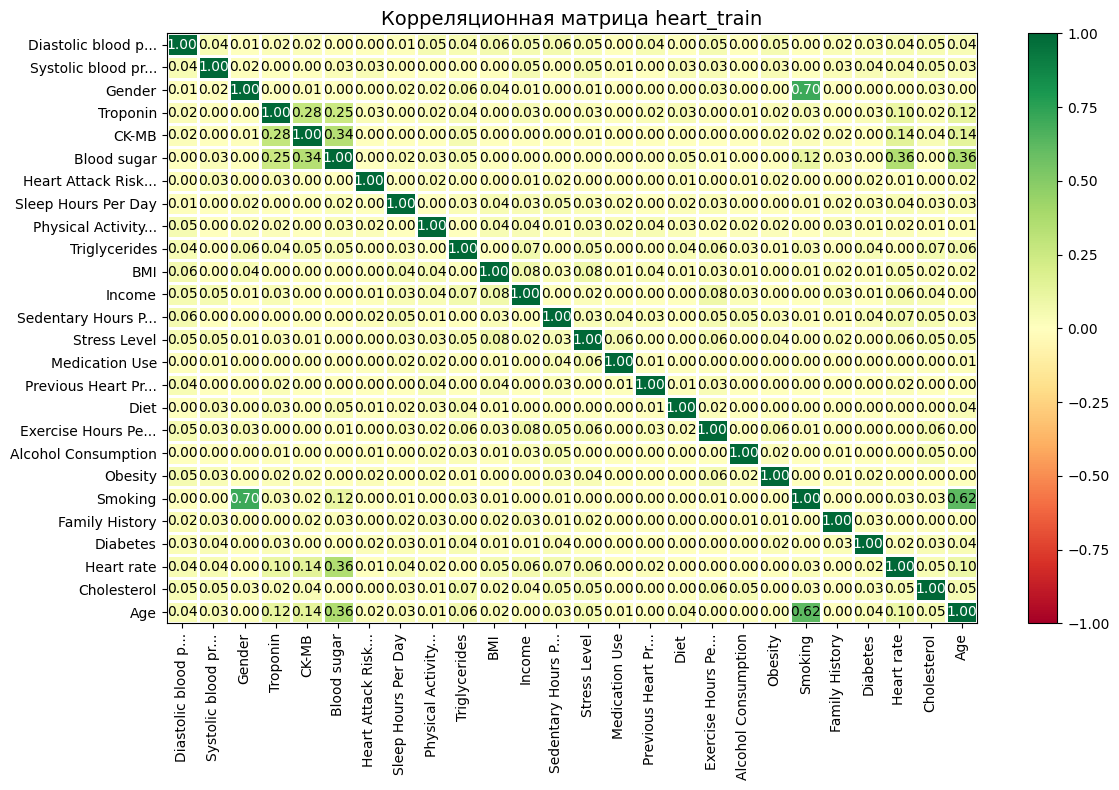

In [86]:
# график корреляции признаков, чтобы посмотреть на наличие значимых связей или мультиколлинеарности
phik_corr = heart_train.phik_matrix(interval_cols = heart_train.columns)

plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title=r"Корреляционная матрица heart_train",
    figsize=(12, 8))

Не думаю, что логически можно связать между собой возраст, факт курения или пол, а тем более выделить одно через другое.  
Поэтому опустим эту корреляцию и посмотрим на график в целом. Насколько я могу судить: 
- признаки практически не связаны друг с другом  
- и почти не влияют на целевой признак.

Это наводит на мысли о том, что сами признаки малоинформативны, но не по логике, т.к. там много значимых показателей,  
а именно по качеству полученных данных. Возможно из-за некорректного метода скейлинга бóльшая часть связей "убилась"  
и теперь мы имеем дело с низкоинформативными признаками.  

Попробуем посмотреть на распределения признаков, чтобы найти что-то, что мы сможем использовать.  
Заодно сравним насколько похожи данные train и test файлов.  

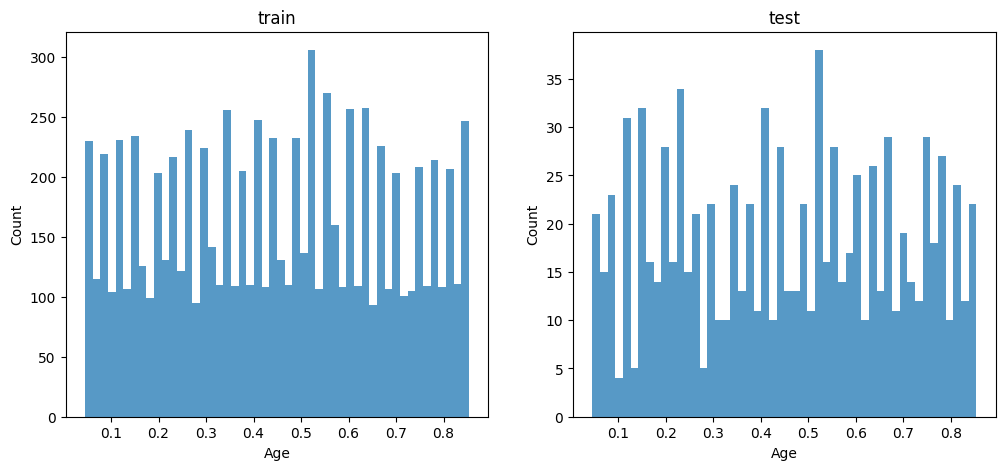

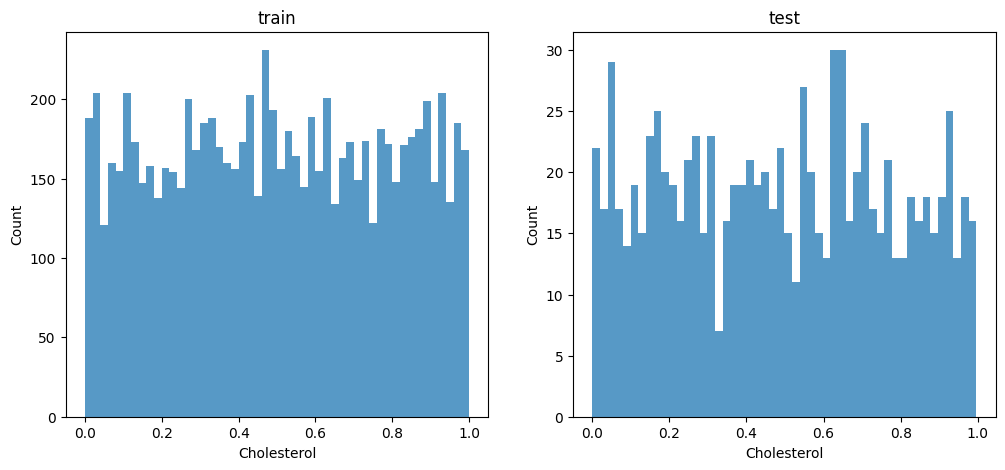

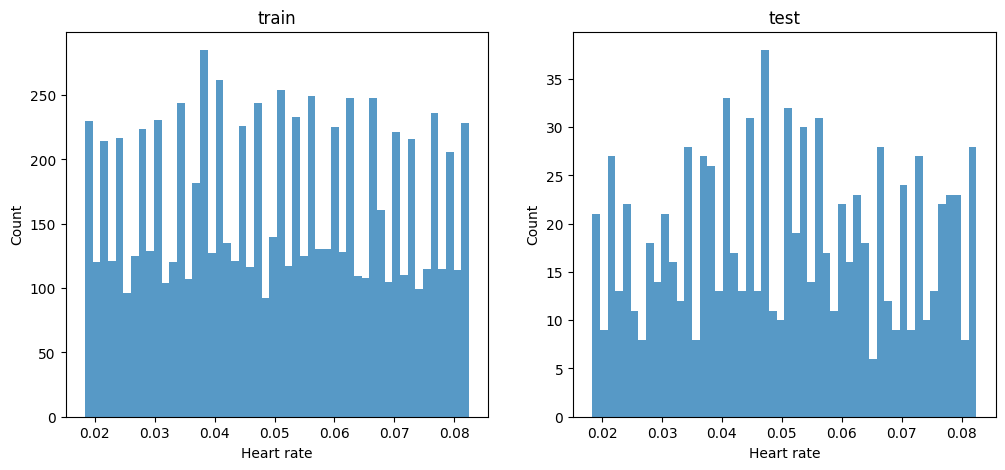

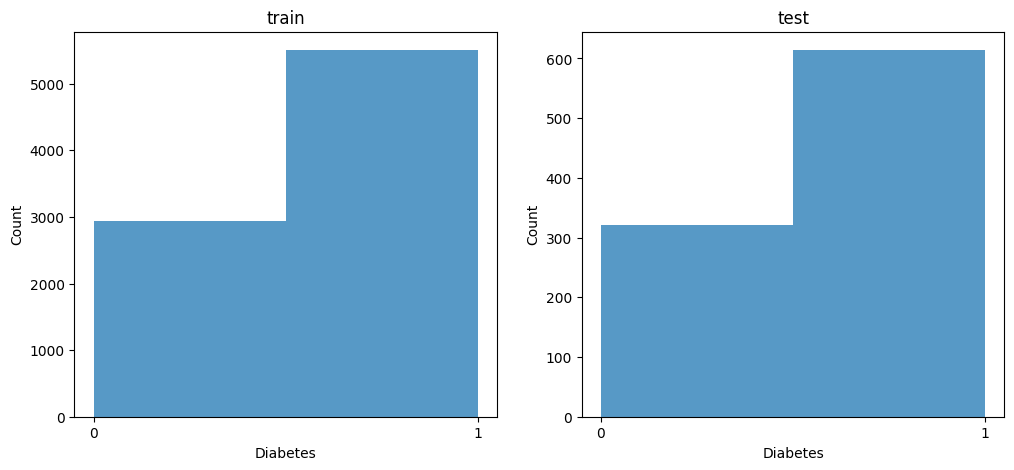

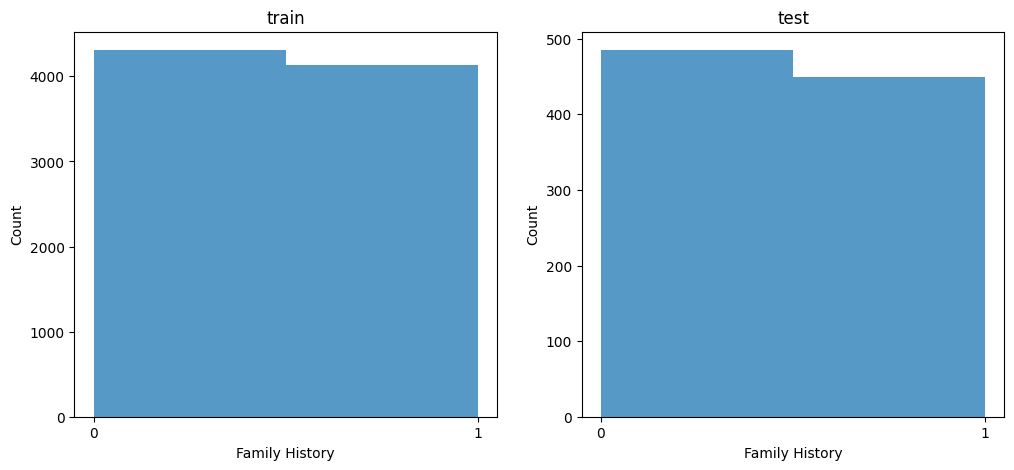

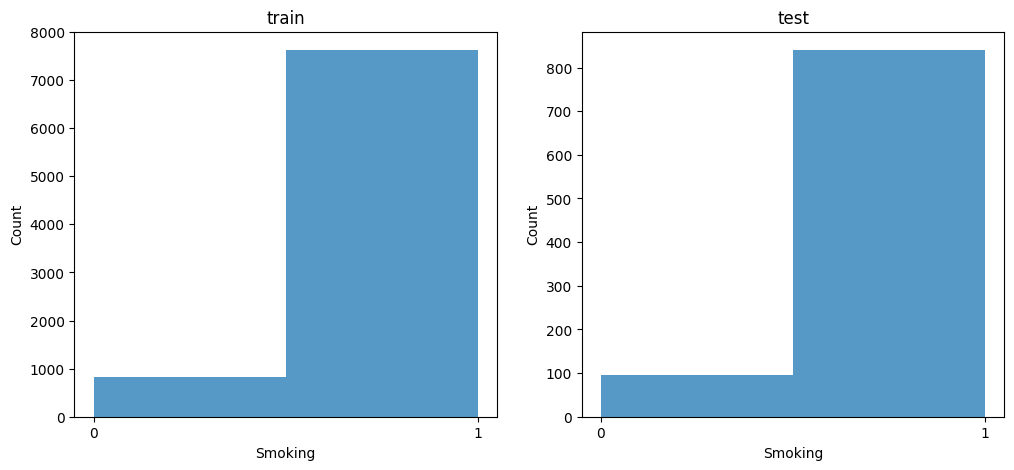

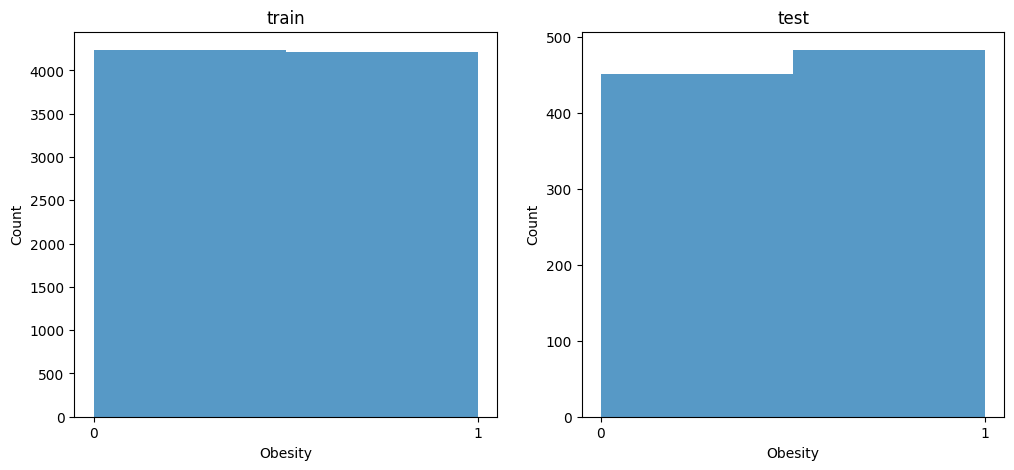

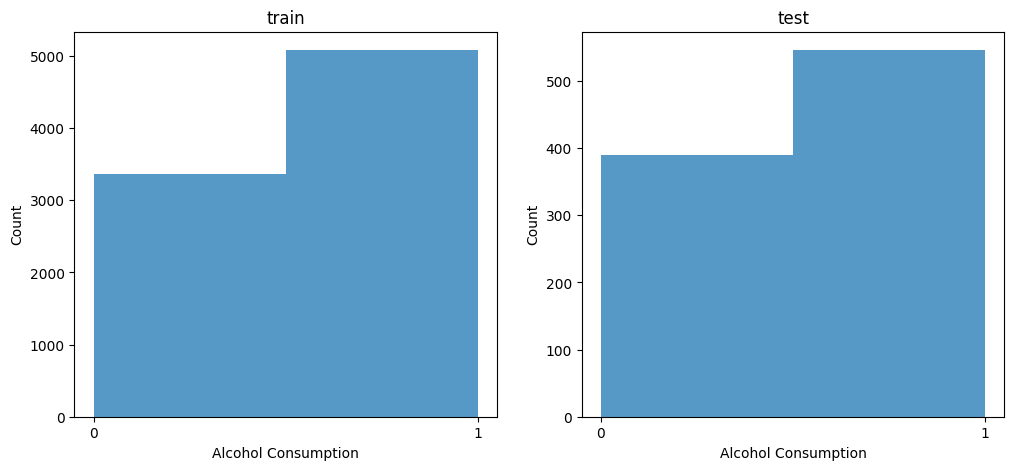

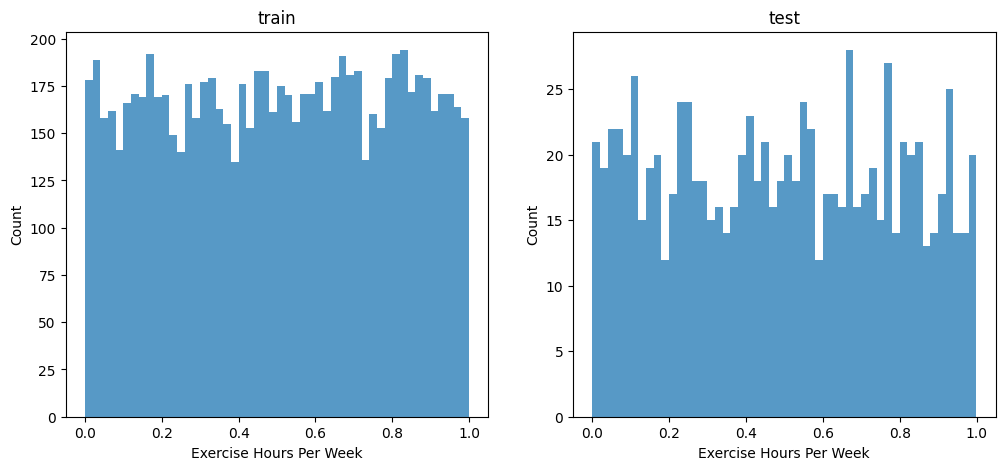

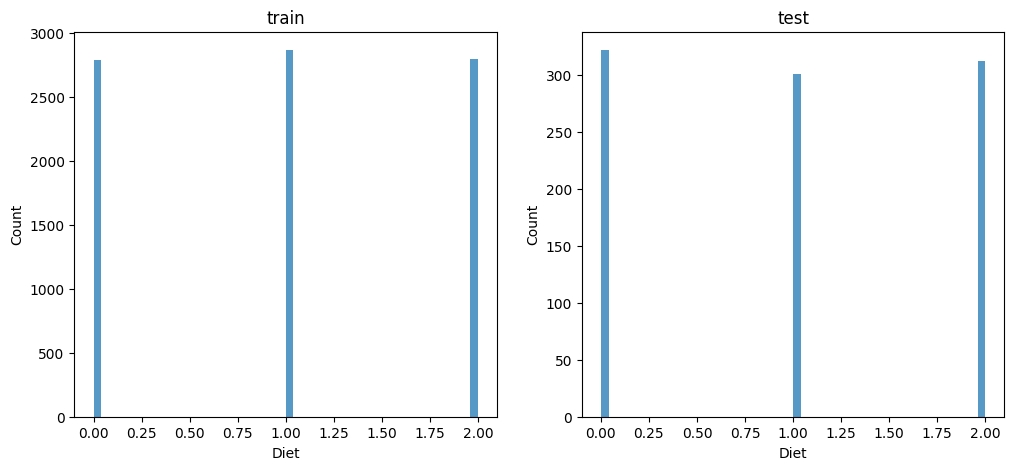

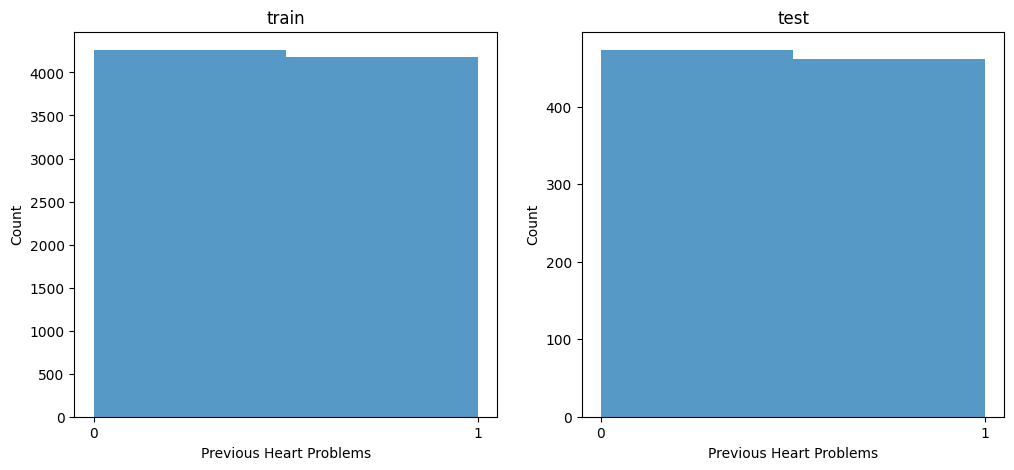

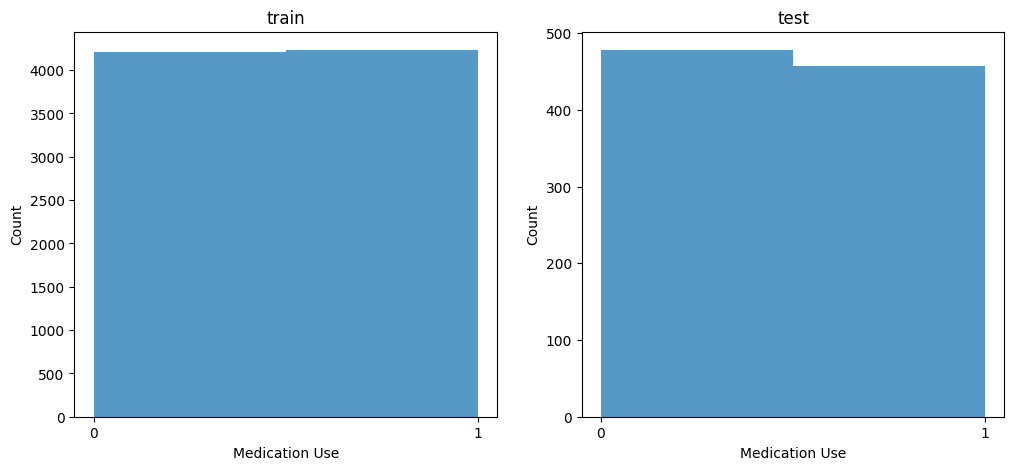

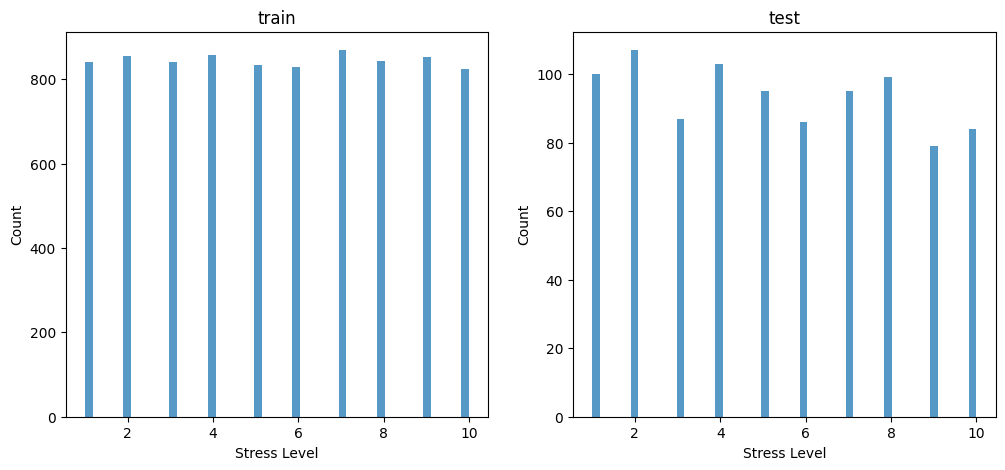

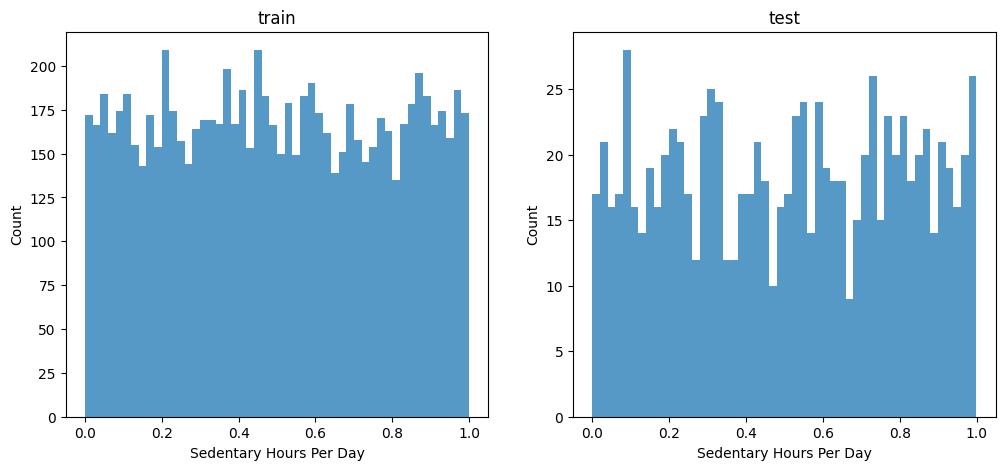

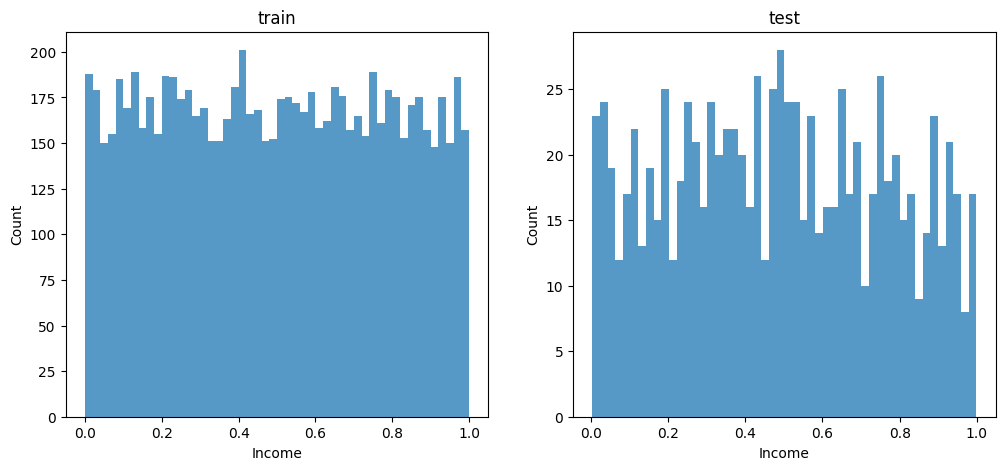

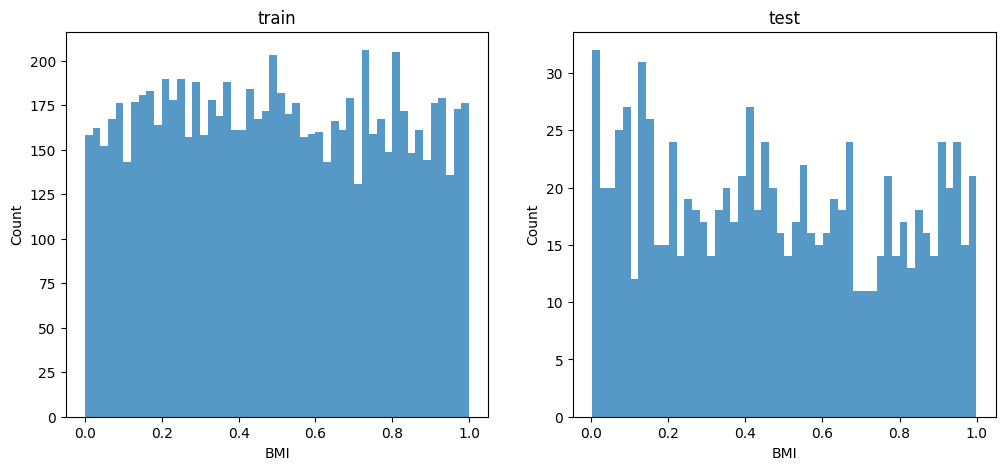

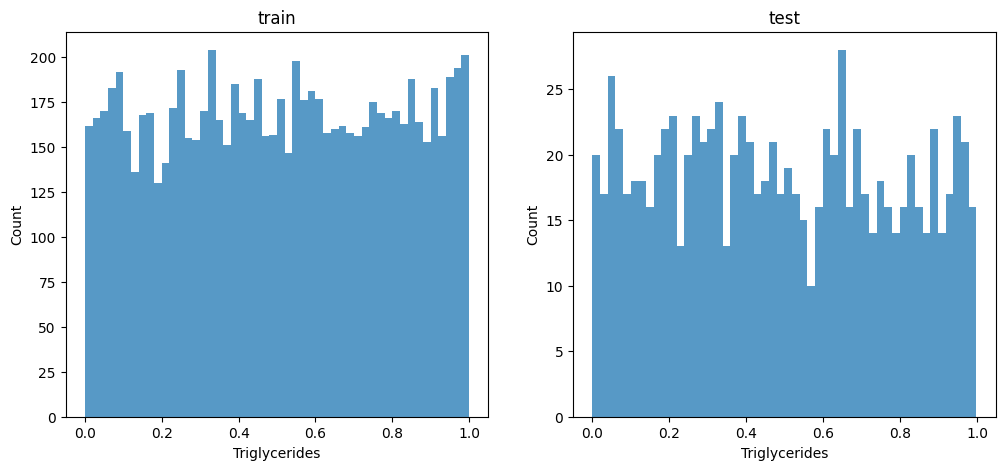

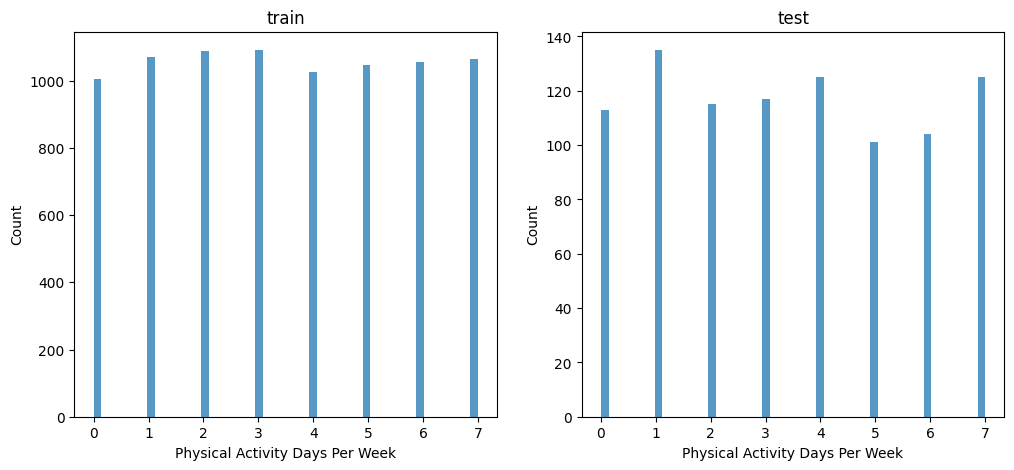

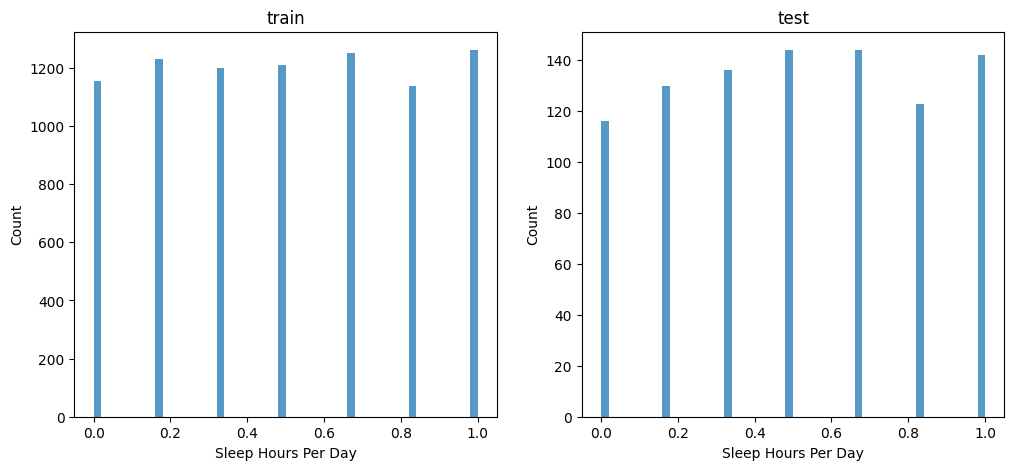

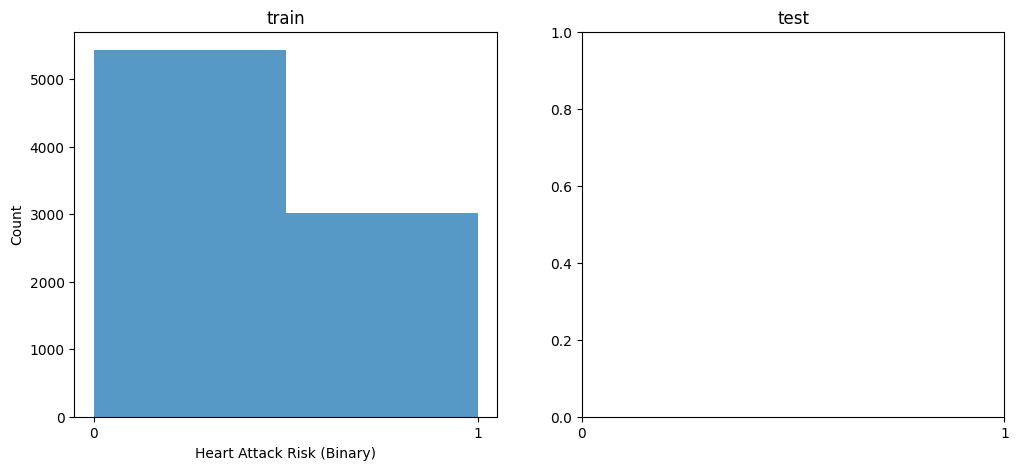

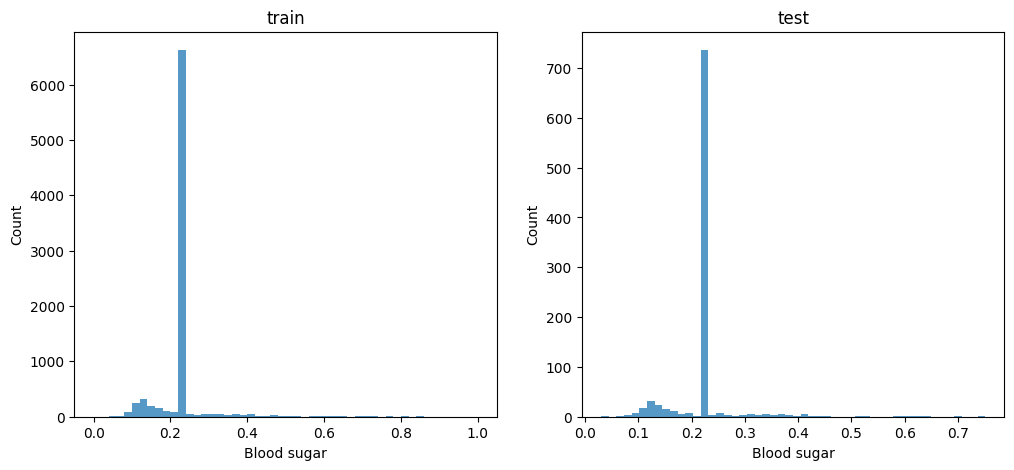

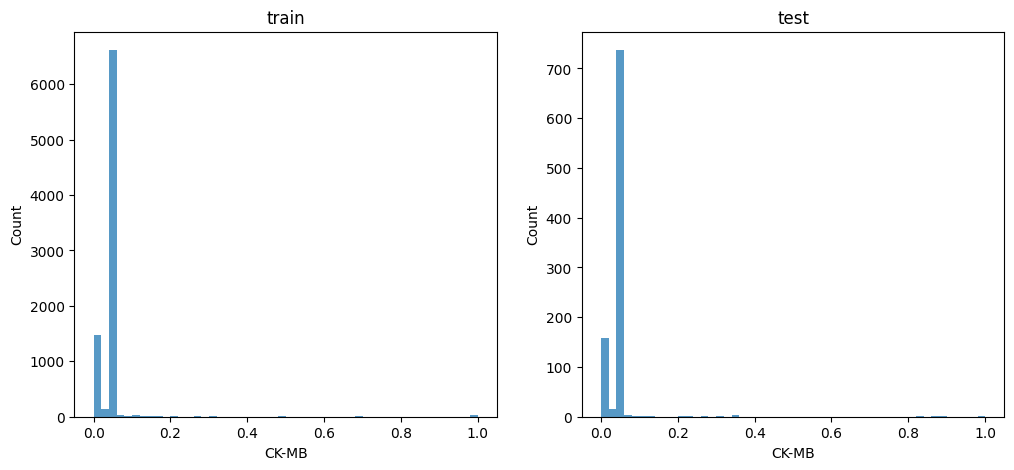

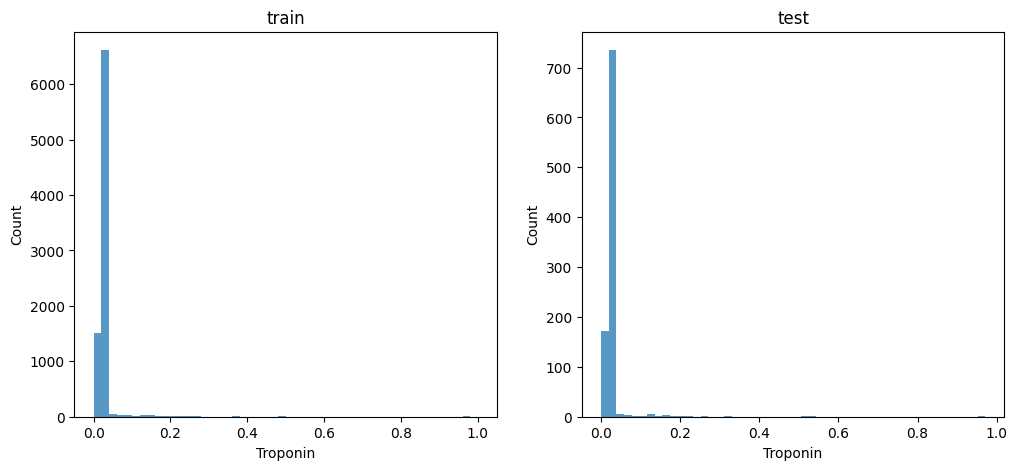

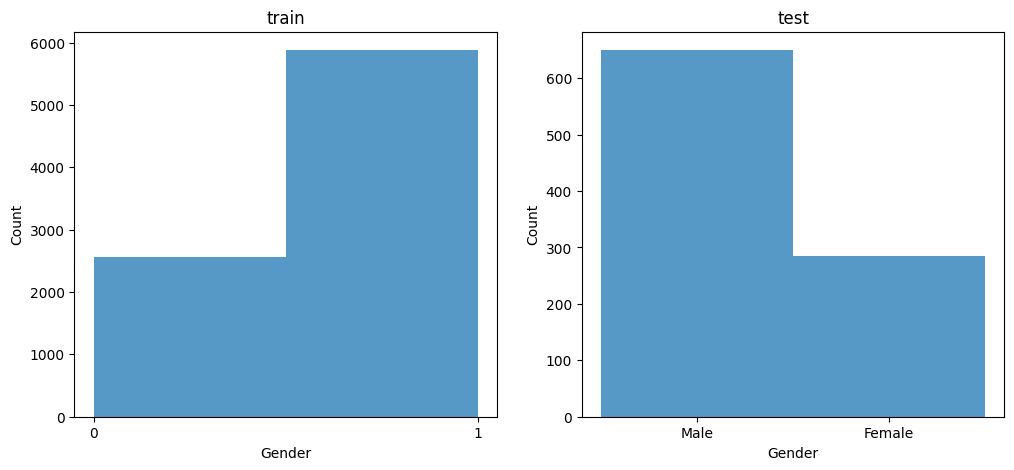

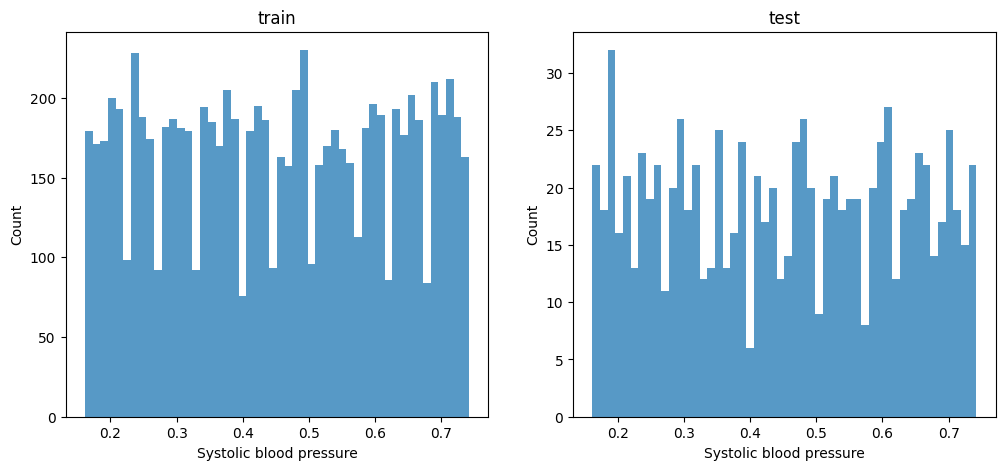

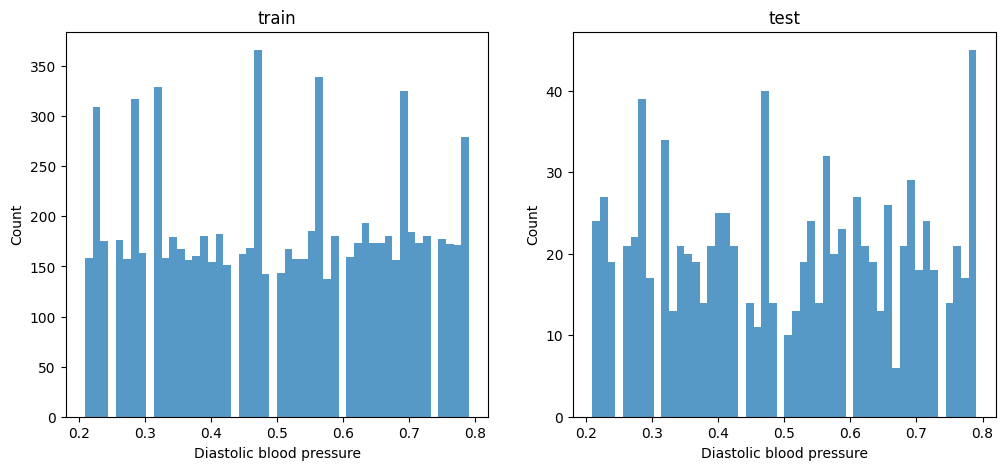

In [87]:
# строим две оси с графиками
for col in heart_train.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    if heart_train[col].nunique() != 2:
        sns.histplot(heart_train[col], bins=50, linewidth=0, ax=axes[0])

        try:
            sns.histplot(heart_test[col], bins=50, linewidth=0, ax=axes[1])
        except:
            pass
    else:
        sns.histplot(heart_train[col], bins=2, linewidth=0, ax=axes[0])
        
        try:
            sns.histplot(heart_test[col], bins=2, linewidth=0, ax=axes[1])
        except:
            pass

        axes[0].set_xticks(heart_train[col].unique())
        axes[1].set_xticks(heart_train[col].unique())
    
    axes[0].set_title('train')
    axes[1].set_title('test')
    plt.show()

В целом, сильной разницы между train и test данными я не обнаружил.  
Конечно есть минорные различия в распределении частот, но в первую очередь я связываю это с тем,   
что в тренировочных данных гораздо больше строк, а потому графики меньше колеблятся по оси Y (частота). 

Что действительно смущает, так это графики частоты у тропонина, CK-MB и сахара в крови.  
Там наблюдаются очень большие частотные всплески, я считаю это следствие неправильного скейлинга,   
где бóльшая часть распределения сжалась до одного значения, из-за чего у нас в будущем будет много проблем.  

Попробуем найти корреляцию между средним значением целевого признака и остальных признаков.  
Т.е. посмотреть долю инфарктов при том или ином значении бинарных признаков.  

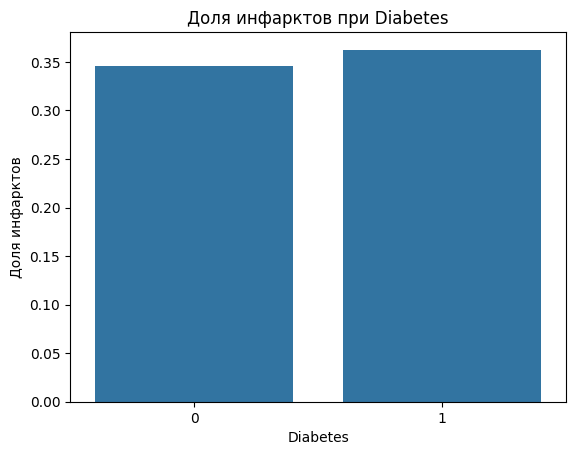

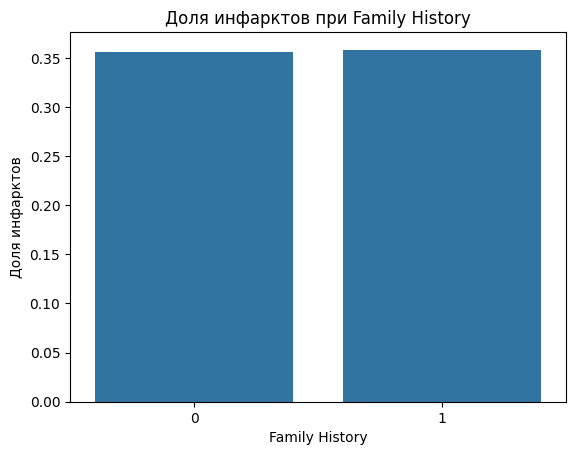

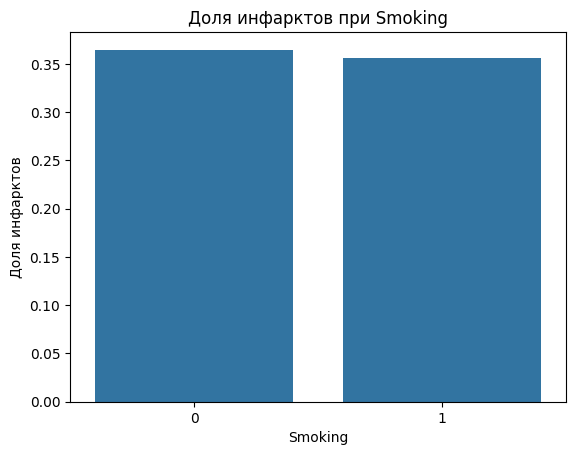

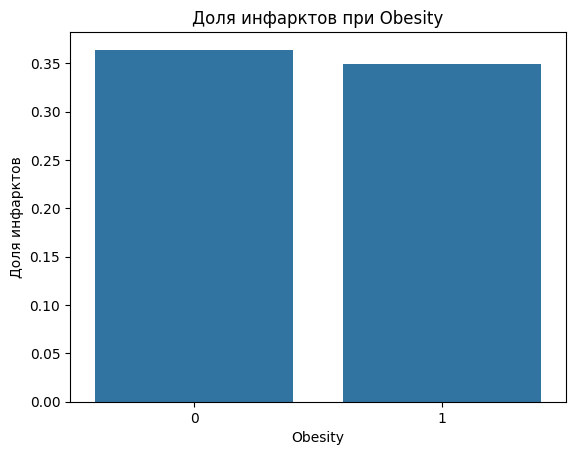

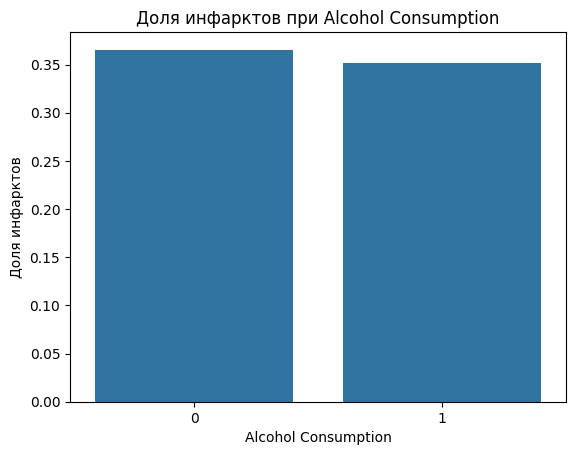

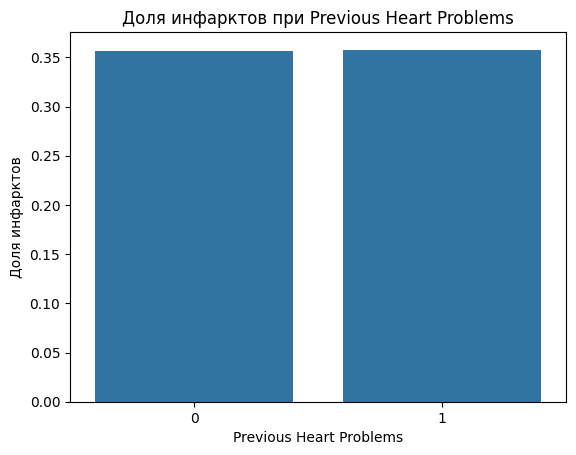

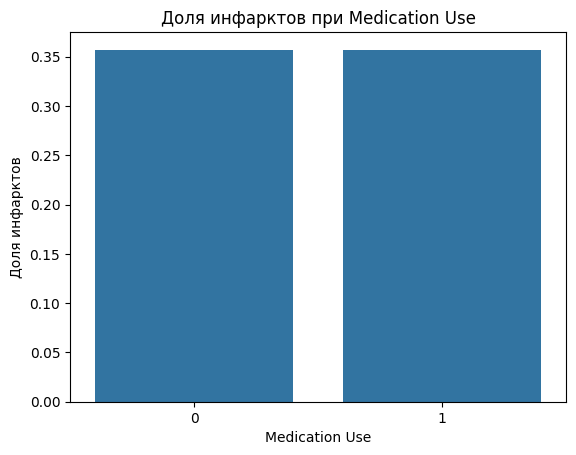

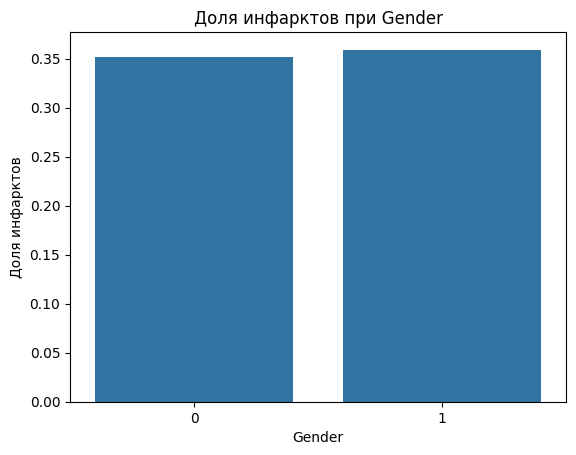

In [88]:
# построим график
for col in heart_train.select_dtypes(include='number').columns:
    if col != 'Heart Attack Risk (Binary)' and heart_train[col].nunique() == 2:
        rate = heart_train.groupby(col)['Heart Attack Risk (Binary)'].mean()
        sns.barplot(x=rate.index, y=rate.values)
        plt.title(f'Доля инфарктов при {col}')
        plt.ylabel('Доля инфарктов')
        plt.xlabel(col)
        plt.show()

Ожидалось, что негативные привычки и образ жизни будут прямо влиять на целевой признак, но в рамках этих значений это не так.   
Что совершенно нелогично и снова отсылает нас к проблеме с качеством данных.  

Также у нас есть пара кандидатов на утечку данных:  
`CK-MB` — изофермент креатинфосфокиназы, маркёр повреждения сердечной мышцы (повышается при инфаркте миокарда).    
`Troponin` — белок, выделяющийся при повреждении сердечной мышцы. Один из наиболее точных показателей инфаркта.  
`Previous Heart Problems` — наличие ранее диагностированных проблем с сердцем (1 — да, 0 — нет).   

Наличие ранее диагностированных проблем с сердцем мы проверили выше, а остальные проверим ниже:

In [89]:
heart_train.groupby('Heart Attack Risk (Binary)')['CK-MB'].mean()

Heart Attack Risk (Binary)
0   0.05
1   0.05
Name: CK-MB, dtype: float64

In [90]:
heart_train.groupby('Heart Attack Risk (Binary)')['Troponin'].mean()

Heart Attack Risk (Binary)
0   0.04
1   0.04
Name: Troponin, dtype: float64

Мы не видим следствий теоретической утечки данных, а раз мы не видим следствий утечки, то будем считать, что в рамках текущих данных её нет.  

# Шаг 3. Построение модели

Кодировать категриальные признак нам не придется, т.к. он был всего один и его мы закодировали вручную ранее.  
Скейлить тоже нет необходимости, т.к. признаки либо бинарные, либо уже отскейлены заранее (наши исходные данные).  
Поэтому просто подготовим пайплайн с перебором моделей и гиперпараметров к ним.  

Для проверки качества модели мы будем использовать F-бету с beta=2, это параметр, который значительно усиливает вес Recall,   
т.к. нам важнее не потерять пациентов с риском инфаркта, нежели ошибочно записать их на обследование.  

Сперва попробуем решить задачу классическими моделями, с которыми мы имели дело в прошлом.

In [91]:
# выделяем таргет
X = heart_train.drop('Heart Attack Risk (Binary)', axis=1)
y = heart_train['Heart Attack Risk (Binary)']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# создадим пайплайн с моделями
pipeline = Pipeline([
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'models__C': range(1, 5)
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5)
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)]
    }
]

# создаем кастомную метрику
f2_scorer = make_scorer(fbeta_score, beta=2)

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE)

randomized_search.fit(X_train, y_train)

print("Лучшие параметры:", randomized_search.best_params_)

best_model = randomized_search.best_estimator_

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 300)
    scores = [fbeta_score(y_true, (y_pred_proba > t).astype(int), beta=2) for t in thresholds]
    best_t = thresholds[np.argmax(scores)]
    best_score = max(scores)
    return best_t, best_score

valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]
best_t, best_fbeta = find_best_threshold(y_valid, valid_pred_proba)

print(f'Лучший порог: {round(best_t, 2)}, его F2-score: {round(best_fbeta, 2)}')

Лучшие параметры: {'models__n_neighbors': 3, 'models': KNeighborsClassifier()}
Лучший порог: 0.01, его F2-score: 0.61


In [92]:
# посмотрим на предсказания
y_pred = (valid_pred_proba >= best_t).astype(int)

check = pd.DataFrame(zip(y_valid, y_pred), columns=['y_valid', 'y_pred']).value_counts().sort_values()

check

y_valid  y_pred
1        0         202
0        0         436
1        1         551
0        1         922
Name: count, dtype: int64

Результат довольно слабый, попробуем повысить качество нашей модели и подобрать другие алгоритмы.  

# Шаг 4. Повышение качества модели

Сперва займемся инжинирингом новых признаков:
- проверим существует ли порог, в каждом из непрерывных признаков, после которого доля инфарктов возрастает
- создадим логически возможные комбинации признаков, исходя из информации мед. источников в интернете
- и возведением значения всех признаков в квадрат, чтобы попробовать усилить связь с цел. признаком

Затем выберем алгоритмы, которые будут устойчивы к мультколлинеарности,   
которая неизбежно появится из-за шага выше, после чего посмотрим на значение fbeta новой модели.  

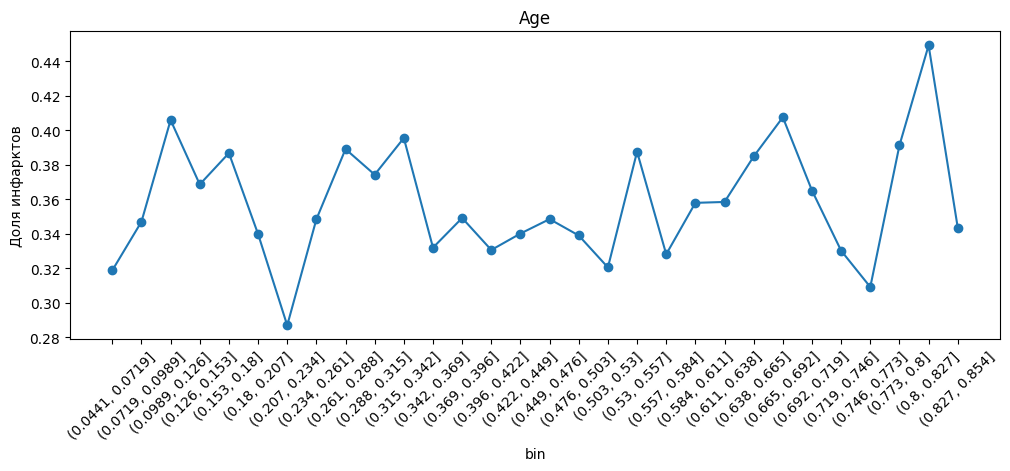

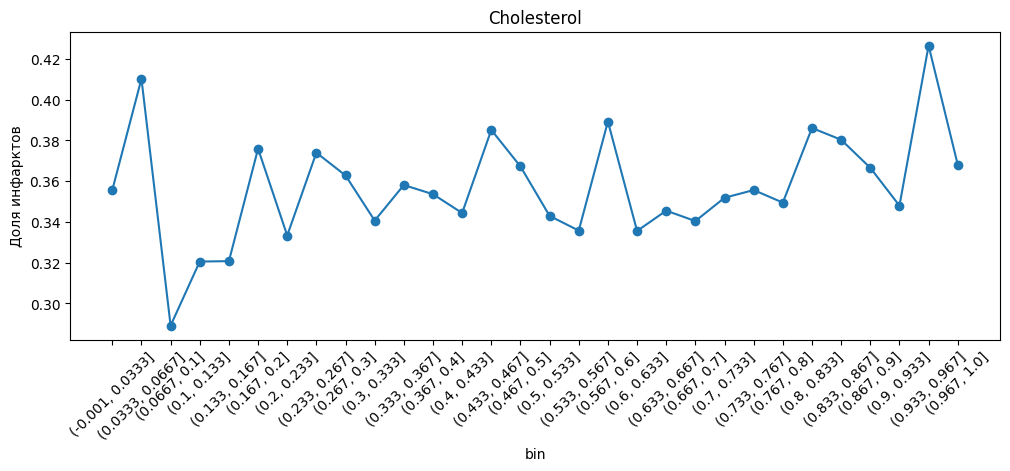

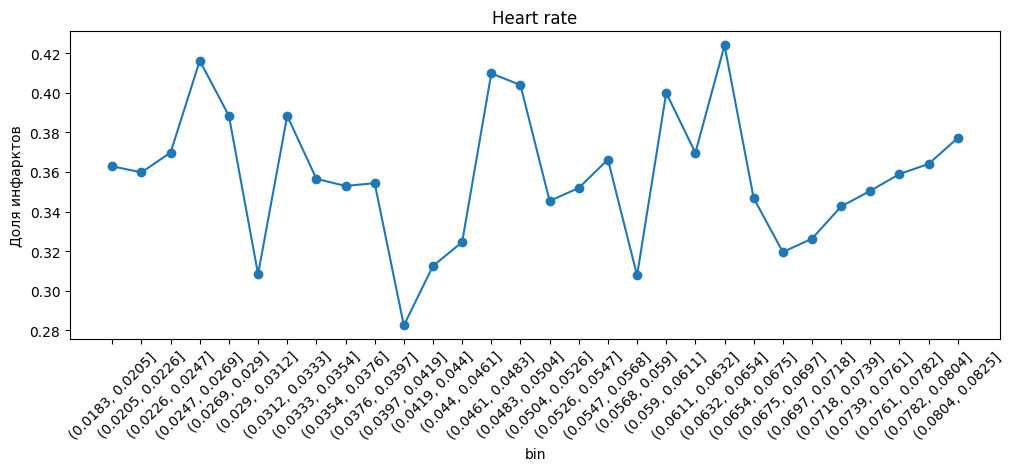

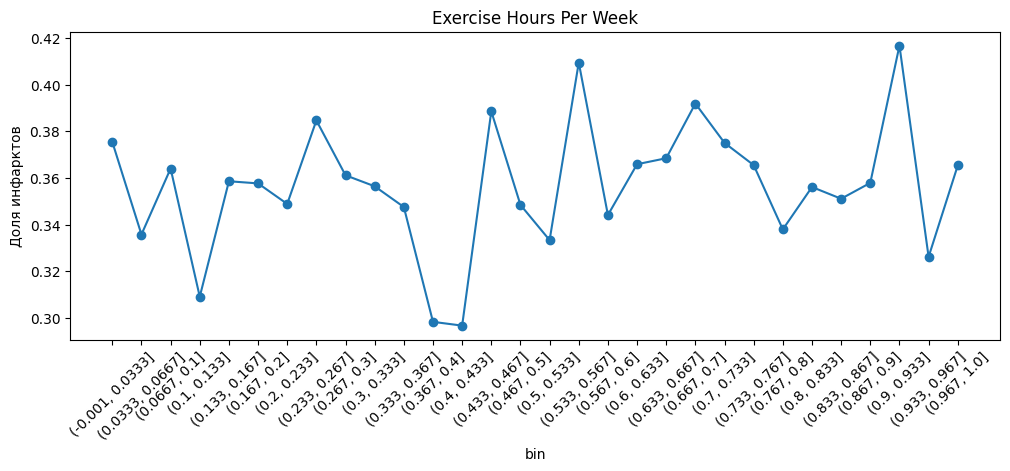

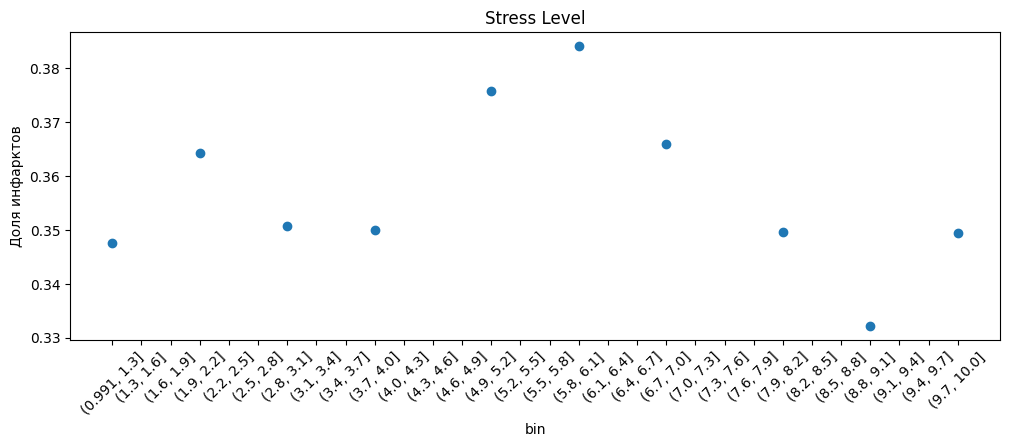

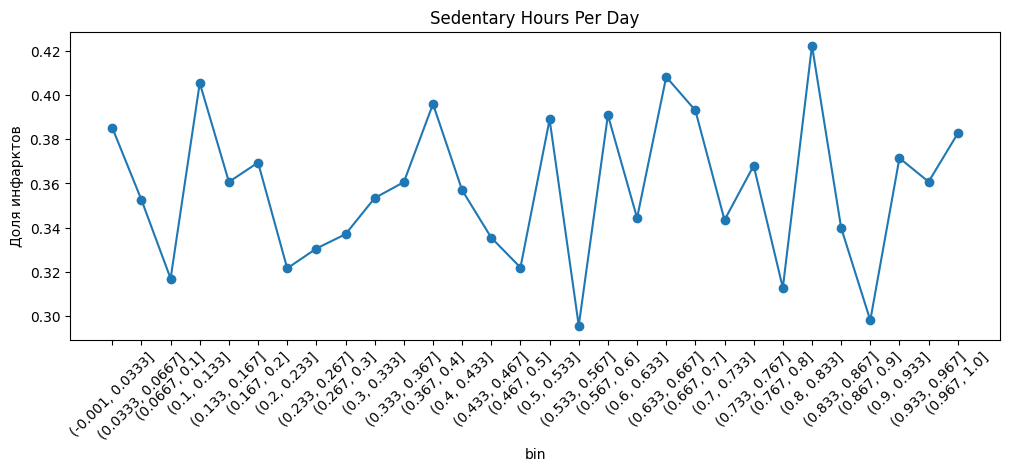

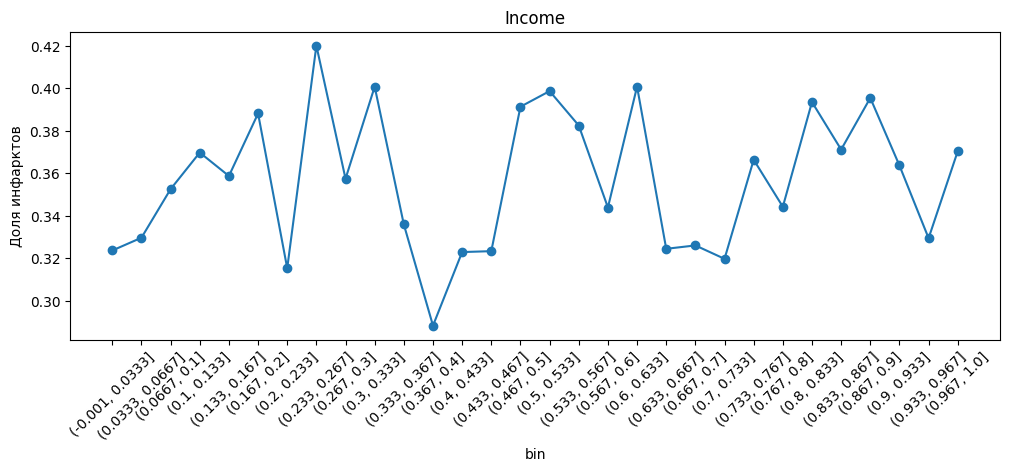

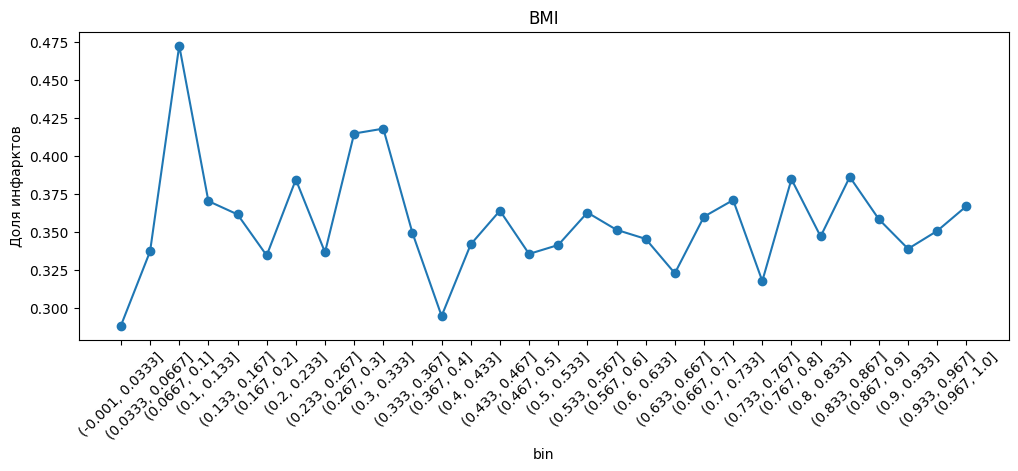

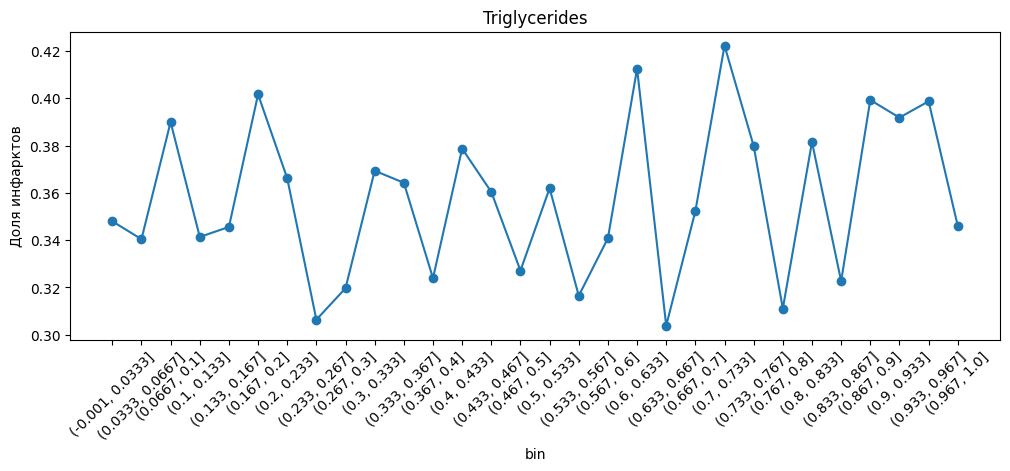

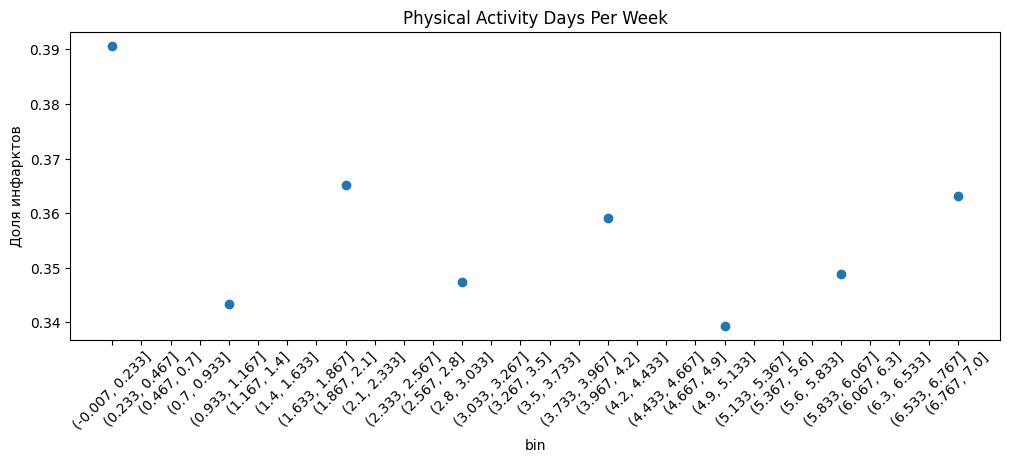

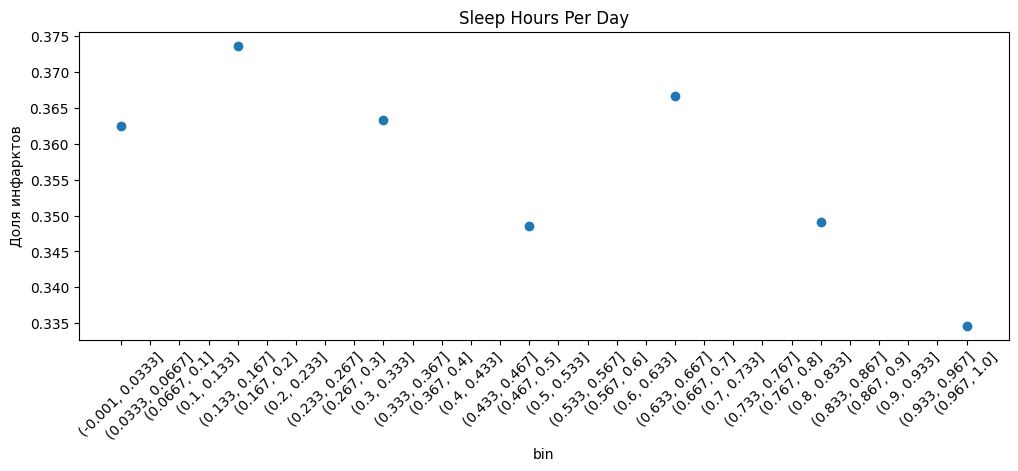

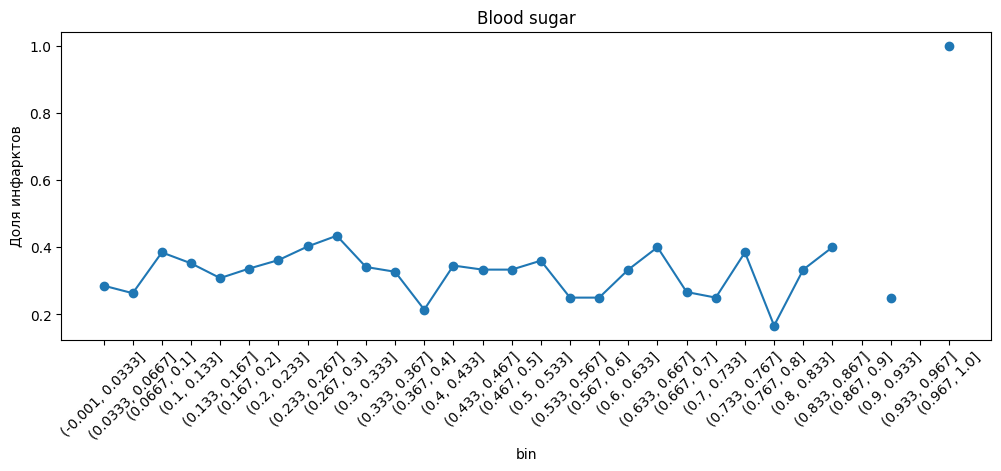

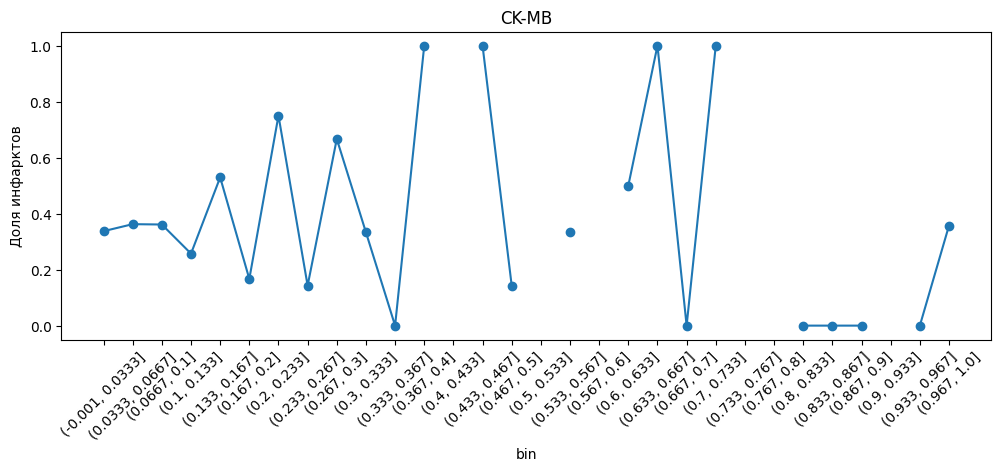

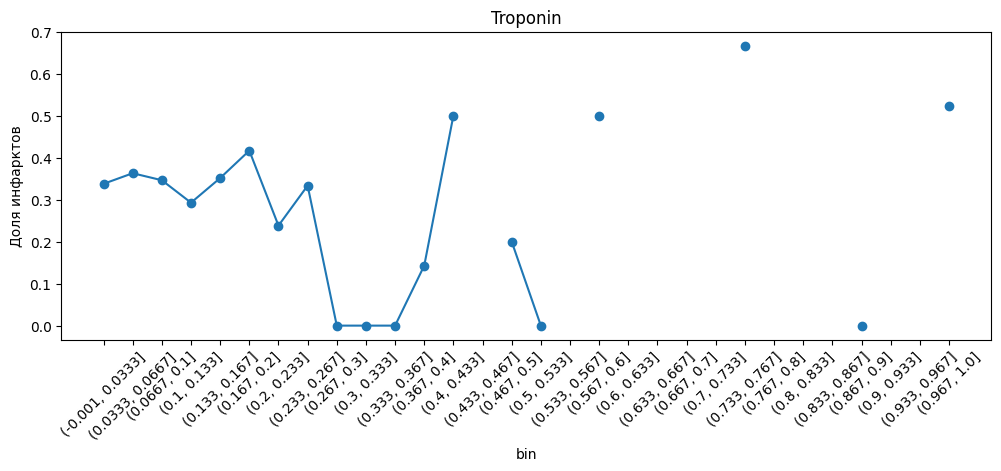

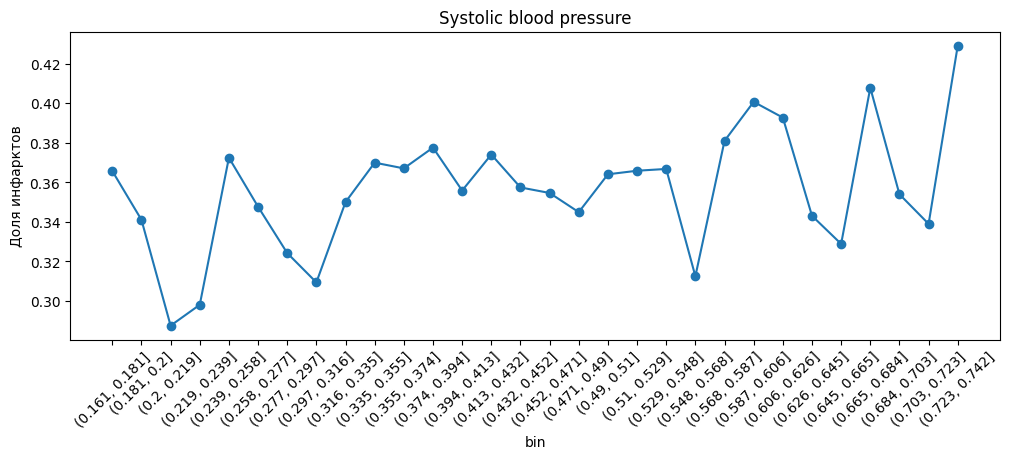

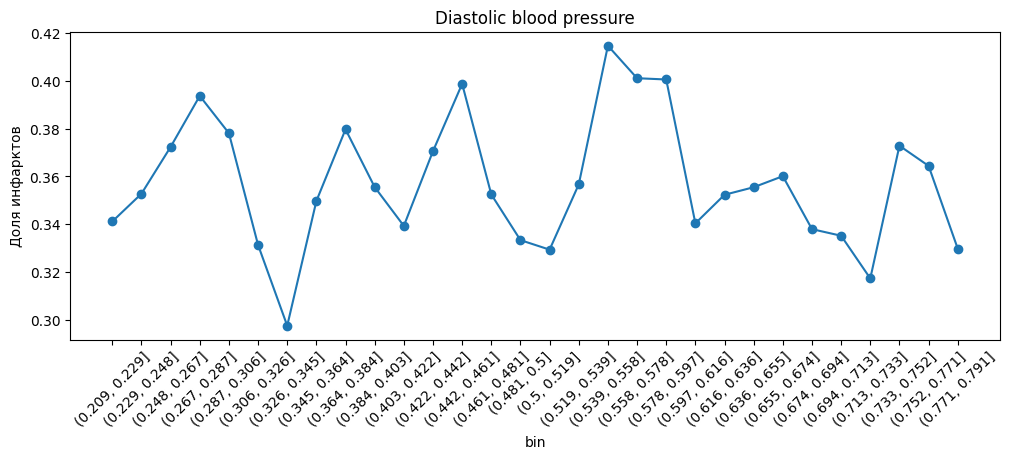

In [93]:
features = heart_train.select_dtypes(include='number').drop('Heart Attack Risk (Binary)', axis=1)

for col in features.columns:
    if features[col].nunique() not in [2,3]: # оставляем непрерывные признаки
        plt.figure(figsize=(12,4))
        heart_train['bin'] = pd.cut(heart_train[col], bins=30)
        rate = heart_train.groupby('bin')['Heart Attack Risk (Binary)'].mean()
        rate.plot(marker='o')
        plt.title(col)
        plt.ylabel('Доля инфарктов')
        plt.xticks(range(len(rate)), [str(interval) for interval in rate.index], rotation=45)
        plt.show()

heart_train = heart_train.drop('bin', axis=1)


К сожалению я не вижу какого-то порога, после которого можно выделить ряд значений, чтобы сделать новый признак.  
Поэтому перейдем к созданию признаков.  

In [94]:
# делаем бэкап
df = heart_train.copy()

# 1. Age * Cholesterol
df['age_chol_mul'] = df['Age'] * df['Cholesterol']

# 2. Systolic * Diastolic blood pressure
df['sys_dias_mul'] = df['Systolic blood pressure'] * df['Diastolic blood pressure']

# 3. Stress * Sedentary Hours
df['stress_sedent_mul'] = df['Stress Level'] * df['Sedentary Hours Per Day']

# 4. Triglycerides / Physical Activity
df['trig_to_activity'] = np.where(df['Physical Activity Days Per Week'] != 0,
                                  df['Triglycerides'] / df['Physical Activity Days Per Week'], 0)

# 5. Sleep * Stress
df['sleep_stress_mul'] = df['Sleep Hours Per Day'] * df['Stress Level']

df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,age_chol_mul,sys_dias_mul,stress_sedent_mul,trig_to_activity,sleep_stress_mul
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.36,0.73,0.07,1,1,1,1,1,0.54,1,1,0,8.00,0.23,0.11,0.46,0.98,3.00,0.33,0,0.23,0.05,0.04,1,0.21,0.71,0.26,0.15,1.81,0.33,2.67
9287,0.20,0.33,0.05,1,1,0,0,1,0.07,2,1,0,9.00,0.29,0.16,0.12,0.52,3.00,0.83,0,0.15,0.02,0.00,0,0.41,0.57,0.07,0.24,2.61,0.17,7.50
5379,0.61,0.86,0.06,1,0,1,1,1,0.94,2,1,1,6.00,0.55,0.60,0.37,0.01,2.00,1.00,0,0.23,0.05,0.04,0,0.24,0.22,0.52,0.05,3.30,0.01,6.00
8222,0.73,0.01,0.05,0,0,1,0,1,0.70,0,0,1,3.00,0.33,0.08,0.05,0.13,0.00,0.33,1,0.23,0.05,0.04,0,0.35,0.27,0.01,0.09,0.99,0.00,1.00
4047,0.78,0.76,0.02,0,0,1,0,1,0.41,1,0,0,8.00,0.52,0.34,0.83,0.07,5.00,1.00,1,0.23,0.05,0.04,1,0.62,0.44,0.59,0.27,4.20,0.01,8.00


In [95]:
for col in df.columns.drop('Heart Attack Risk (Binary)'):
    df[col + '_sq'] = df[col] ** 2

df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,age_chol_mul,sys_dias_mul,stress_sedent_mul,trig_to_activity,sleep_stress_mul,Age_sq,Cholesterol_sq,Heart rate_sq,Diabetes_sq,Family History_sq,Smoking_sq,Obesity_sq,Alcohol Consumption_sq,Exercise Hours Per Week_sq,Diet_sq,Previous Heart Problems_sq,Medication Use_sq,Stress Level_sq,Sedentary Hours Per Day_sq,Income_sq,BMI_sq,Triglycerides_sq,Physical Activity Days Per Week_sq,Sleep Hours Per Day_sq,Blood sugar_sq,CK-MB_sq,Troponin_sq,Gender_sq,Systolic blood pressure_sq,Diastolic blood pressure_sq,age_chol_mul_sq,sys_dias_mul_sq,stress_sedent_mul_sq,trig_to_activity_sq,sleep_stress_mul_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.36,0.73,0.07,1,1,1,1,1,0.54,1,1,0,8.00,0.23,0.11,0.46,0.98,3.00,0.33,0,0.23,0.05,0.04,1,0.21,0.71,0.26,0.15,1.81,0.33,2.67,0.13,0.54,0.01,1,1,1,1,1,0.29,1,1,0,64.00,0.05,0.01,0.21,0.96,9.00,0.11,0.05,0.00,0.00,1,0.05,0.50,0.07,0.02,3.26,0.11,7.11
9287,0.20,0.33,0.05,1,1,0,0,1,0.07,2,1,0,9.00,0.29,0.16,0.12,0.52,3.00,0.83,0,0.15,0.02,0.00,0,0.41,0.57,0.07,0.24,2.61,0.17,7.50,0.04,0.11,0.00,1,1,0,0,1,0.00,4,1,0,81.00,0.08,0.03,0.01,0.27,9.00,0.69,0.02,0.00,0.00,0,0.17,0.32,0.00,0.06,6.81,0.03,56.25
5379,0.61,0.86,0.06,1,0,1,1,1,0.94,2,1,1,6.00,0.55,0.60,0.37,0.01,2.00,1.00,0,0.23,0.05,0.04,0,0.24,0.22,0.52,0.05,3.30,0.01,6.00,0.37,0.74,0.00,1,0,1,1,1,0.89,4,1,1,36.00,0.30,0.36,0.14,0.00,4.00,1.00,0.05,0.00,0.00,0,0.06,0.05,0.27,0.00,10.90,0.00,36.00
8222,0.73,0.01,0.05,0,0,1,0,1,0.70,0,0,1,3.00,0.33,0.08,0.05,0.13,0.00,0.33,1,0.23,0.05,0.04,0,0.35,0.27,0.01,0.09,0.99,0.00,1.00,0.53,0.00,0.00,0,0,1,0,1,0.49,0,0,1,9.00,0.11,0.01,0.00,0.02,0.00,0.11,0.05,0.00,0.00,0,0.12,0.07,0.00,0.01,0.99,0.00,1.00
4047,0.78,0.76,0.02,0,0,1,0,1,0.41,1,0,0,8.00,0.52,0.34,0.83,0.07,5.00,1.00,1,0.23,0.05,0.04,1,0.62,0.44,0.59,0.27,4.20,0.01,8.00,0.60,0.57,0.00,0,0,1,0,1,0.17,1,0,0,64.00,0.28,0.12,0.69,0.00,25.00,1.00,0.05,0.00,0.00,1,0.38,0.20,0.34,0.07,17.61,0.00,64.00


Для новой модели мы выбрали следующие алгоримты:
- RandomForestClassifier
- CatBoostClassifier
- XGBClassifier
- LGBMClassifier

In [96]:
X = df.drop('Heart Attack Risk (Binary)', axis=1)
y = df['Heart Attack Risk (Binary)']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

pipeline = Pipeline([
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

# сделаем свой скор, т.к. в sklearn нет встроенного, как в случае с f1
f2_scorer = make_scorer(fbeta_score, beta=2)

param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy'],
        'models__max_depth': [None, 5, 10],
        'models__min_samples_split': range(2,5),
        'models__min_samples_leaf': range(1,5)
    }, 
    {
        'models': [CatBoostClassifier(
            loss_function="Logloss", 
            verbose=0,
            random_state=RANDOM_STATE)],
        'models__iterations': [300, 500, 800],
        'models__depth': [None, 4, 5, 6, 7],
        'models__learning_rate': [0.01, 0.03, 0.05],
        'models__l2_leaf_reg': [1, 3, 5, 7, 9],
        'models__border_count': [32, 64, 128]
    },
    {
        'models': [XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=RANDOM_STATE)],
        'models__n_estimators': [200, 400, 600],
        'models__max_depth': [None, 3, 4, 5, 6],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__subsample': [0.7, 0.9, 1.0]
    },
    {
        'models': [LGBMClassifier(
            objective='binary',
            random_state=RANDOM_STATE)],
        'models__n_estimators': [300, 500, 800],
        'models__learning_rate': [0.01, 0.03, 0.05],
        'models__max_depth': [None, -1, 5, 7],
        'models__num_leaves': [31, 63, 127]
    }
]

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE)

randomized_search.fit(X_train, y_train)

print("Лучшие параметры:", randomized_search.best_params_)

best_model = randomized_search.best_estimator_

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 300)
    scores = [fbeta_score(y_true, (y_pred_proba > t).astype(int), beta=2) for t in thresholds]
    best_t = thresholds[np.argmax(scores)]
    best_score = max(scores)
    return best_t, best_score

valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]
best_t, best_fbeta = find_best_threshold(y_valid, valid_pred_proba)

print(f'Лучший порог: {round(best_t, 2)}, его F2-score: {round(best_fbeta, 2)}')

Лучшие параметры: {'models__learning_rate': 0.05, 'models__l2_leaf_reg': 3, 'models__iterations': 800, 'models__depth': None, 'models__border_count': 32, 'models': <catboost.core.CatBoostClassifier object at 0x00000289CCEEDF40>}
Лучший порог: 0.14, его F2-score: 0.74


In [97]:
# снова посмотрим на предсказания
print('Старые предсказания:')
display(check)

y_pred = (valid_pred_proba >= best_t).astype(int)

print('Новые предсказания:')
pd.DataFrame(zip(y_valid, y_pred), columns=['y_valid', 'y_pred']).value_counts().sort_values()

Старые предсказания:


y_valid  y_pred
1        0         202
0        0         436
1        1         551
0        1         922
Name: count, dtype: int64

Новые предсказания:


y_valid  y_pred
1        0           12
0        0          109
1        1          741
0        1         1249
Name: count, dtype: int64

Модель стала явно лучше определять настоящие инфаркты, при этом стало больше ошибок того, что пациентам без риска назначат обследование.  
В рамках этого проекта дальнейшее улучшение метрики я не представляю возможным, поэтому сохраним эту модель как лучшую.  

# Шаг 5. Сохранение лучшей модели



In [98]:
# сохраняем лучшую модель
joblib.dump(best_model, "best_model.pkl")

# сохраняем лучший порог в json
with open("best_threshold.json", "w") as f:
    json.dump({"threshold": float(best_t)}, f)

print("Файлы сохранены:")
print("- best_model.pkl")
print("- best_threshold.json")

Файлы сохранены:
- best_model.pkl
- best_threshold.json
